In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [7]:
device = torch.device("mps")

# Data

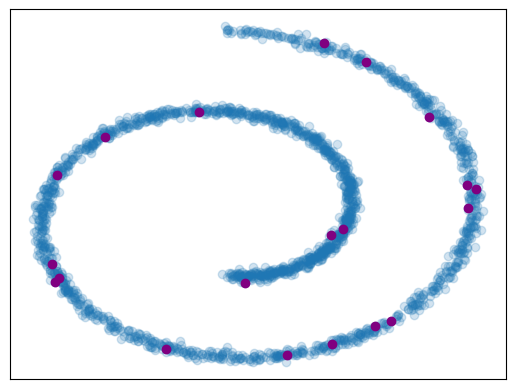

In [8]:
def load_swiss_roll_data(n_samples=400, noise=0.2):
    """
    Generate swiss roll data

    Params:
      - n_samples: number of samples,
      - noise: noise amount,

    Returns:
        torch tensor 2d
    """
    data, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    data_2d = data[:, [0, 2]]
    data_tensor = torch.tensor(data_2d, dtype=torch.float32)
    data_tensor = (data_tensor - data_tensor.mean(dim=0)) / data_tensor.std(dim=0)
    return data_tensor

class SwissRollDataset(Dataset):
    def __init__(self, n_samples=400, noise=0.2):
        self.data = load_swiss_roll_data(n_samples=n_samples, noise=noise)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


def plot_data_points(all_data_tensor, draw_samples=None, ax = None):
    """
    Visualizes 2D data points.

    Parameters:
      - all_data_tensor: torch.Tensor of shape [N, 2] containing the main data points.
      - draw_samples: torch.Tensor or None of shape [M, 2] containing additional points to highlight (plotted in green).
    """
    data_np = all_data_tensor.detach().cpu().numpy()

    canvas = ax if ax is not None else plt.gca()

    if draw_samples is not None:
        draw_samples_np = draw_samples.detach().cpu().numpy()
    else:
        draw_samples_np = None

    alpha_value = 0.2 if draw_samples_np is not None else 1.0
    canvas.scatter(data_np[:, 0], data_np[:, 1], alpha=alpha_value)

    if draw_samples_np is not None:
        canvas.scatter(draw_samples_np[:, 0], draw_samples_np[:, 1], c="purple")

    canvas.set_xticks([])
    canvas.set_yticks([])

data = SwissRollDataset(n_samples=2000, noise=0.2)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

plot_data_points(data[:], data[0:20])

# 1. Diffusion Schedule (Расписание шума)

In [102]:
from abc import ABC, abstractmethod
import torch

class BaseDiffusionSchedule(ABC):
    @abstractmethod
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        """
        Abstract base class for diffusion schedules.
        Should be defined by subclasses.:
          - sqrt_alphas_cumprod,
          - sqrt_one_minus_alphas_cumprod.
        """
        pass

    @abstractmethod
    def get_index(self, t):
        """
        Abstract method that returns (sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod) for the time step t.

        Params:
        - t: time step,

        Returns:
            (sqrt alphas cumprod at t, sqrt one minus alphas cumprod at t)
        """
        pass

class LinearDiffusionSchedule(BaseDiffusionSchedule):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, device='mps'):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def get_index(self, t):
        return self.sqrt_alphas_cumprod[t], self.sqrt_one_minus_alphas_cumprod[t]


In [103]:
noise_scheduler = LinearDiffusionSchedule(100)

first = noise_scheduler.get_index(4)

first

(tensor(0.9987, device='mps:0'), tensor(0.0501, device='mps:0'))

In [104]:
def forward_diffusion_sample(x_0, t, device=device):
    """
    Takes the origial state of the vector and add noise to it accordingly to the timestep t.

    Params:
    - x_0: torch tensor 2d
    - t: time step,

    Returns:
        The noisy version of vector at timestep t,
    """
    noise = torch.randn_like(x_0, device=device)
    sqrt_alphas_cumprod_t = noise_scheduler.sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = noise_scheduler.sqrt_one_minus_alphas_cumprod[t]
    noisy = sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy, noise

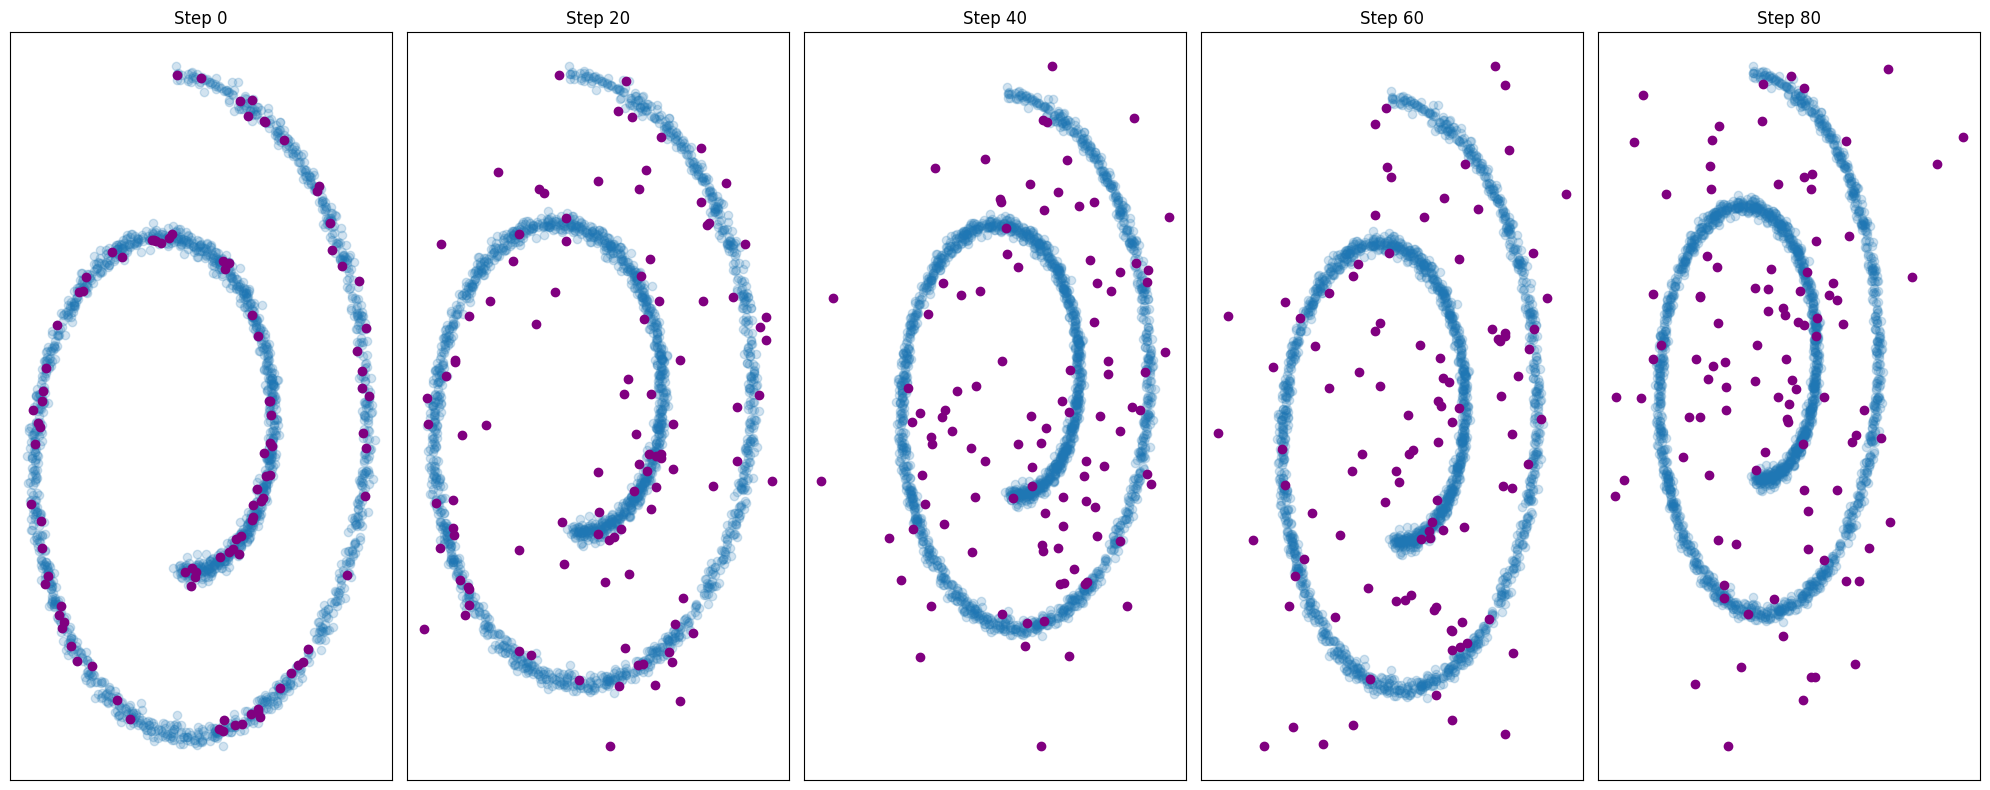

In [105]:
test_vecs = data[0:100]

test_vecs_display = test_vecs.clone()

timesteps = torch.arange(100)

k = 20

fig, axes = plt.subplots(1, len(timesteps) // k, figsize=(20, min(8, 2 * k)))

for i, timestep in enumerate(timesteps):
    if  i % k == 0:
        ax = axes[i // k]
        ax.set_title(f"Step {timestep.item()}")
        plot_data_points(data[:], test_vecs_display, ax)

    test_vecs_display = forward_diffusion_sample(test_vecs, timestep)[0]

plt.tight_layout()
plt.show()


# Basic ANN for noise estimation

In [85]:
import random

class NoiseEstimator(nn.Module):
    def __init__(self, input_dim, timestep_dim):
        """
        Initializes a basic Multi-Layer Perceptron (MLP) model.

        Parameters:
        - input_dim: Dimension of the input features.
        - timestep_dim: Dimension of the hidden layers.
        """
        super(NoiseEstimator, self).__init__()

        self.time_embedding = nn.Sequential(
            nn.Linear(1, timestep_dim),
            nn.ReLU(),
            nn.Linear(timestep_dim, timestep_dim)
        ).to(device)

        self.model = nn.Sequential(
            nn.Linear(input_dim + timestep_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        ).to(device)


    def forward(self, data, timestep):
        time_step = torch.full((data.shape[0], 1), float(timestep), dtype=torch.float, device=data.device)
        t_emb = self.time_embedding(time_step)
        x_input = torch.cat([data, t_emb], dim=1)
        noise_pred = self.model(x_input)
        return noise_pred

# Train

In [106]:
def train(model, data_loader, optimizer, epochs=100):
    """
    Обучает модель на 2D данных (например, Swiss Roll):
      - Перебирает данные батчами,
      - Для каждого батча случайно выбирает t,
      - Вычисляет функцию потерь и обновляет параметры модели.
    """
    model.train()
    epoch_loss = []
    for epoch in range(epochs):

        acc_loss = 0

        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)

            timestep = random.randint(0, noise_scheduler.timesteps-1)

            noised_vectors, actual_noise = forward_diffusion_sample(data, timestep)

            predicted_noise = model(noised_vectors, timestep)

            loss = F.mse_loss(predicted_noise, actual_noise)

            acc_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: Loss = {np.mean(acc_loss):.4f}")
        epoch_loss.append(np.mean(acc_loss))

        plt.plot(epoch_loss)

In [97]:
noise_model = NoiseEstimator(input_dim=2, timestep_dim=16)

In [98]:
optimizer_instance = torch.optim.Adam(noise_model.parameters(), lr=0.001)

In [99]:
train_acc = train(noise_model, train_loader, epochs=100, optimizer=optimizer_instance)

Epoch 0: Loss = 12.6850
Epoch 1: Loss = 8.0704
Epoch 2: Loss = 6.1876
Epoch 3: Loss = 5.8916
Epoch 4: Loss = 5.0713
Epoch 5: Loss = 5.0308
Epoch 6: Loss = 4.4091
Epoch 7: Loss = 5.0312
Epoch 8: Loss = 4.2129
Epoch 9: Loss = 4.1686
Epoch 10: Loss = 4.0196
Epoch 11: Loss = 4.7205
Epoch 12: Loss = 4.4732
Epoch 13: Loss = 3.7112
Epoch 14: Loss = 4.5441
Epoch 15: Loss = 5.0163
Epoch 16: Loss = 3.9769
Epoch 17: Loss = 3.6372
Epoch 18: Loss = 3.4162
Epoch 19: Loss = 4.3976
Epoch 20: Loss = 3.9661
Epoch 21: Loss = 4.2188
Epoch 22: Loss = 5.0374
Epoch 23: Loss = 3.8021
Epoch 24: Loss = 3.6119
Epoch 25: Loss = 4.0189
Epoch 26: Loss = 4.3488
Epoch 27: Loss = 2.7049
Epoch 28: Loss = 2.9946
Epoch 29: Loss = 4.3332
Epoch 30: Loss = 4.0334
Epoch 31: Loss = 4.3935
Epoch 32: Loss = 3.3898
Epoch 33: Loss = 3.8982
Epoch 34: Loss = 4.5652
Epoch 35: Loss = 3.4722
Epoch 36: Loss = 4.5586
Epoch 37: Loss = 3.9279
Epoch 38: Loss = 3.7993
Epoch 39: Loss = 4.1125
Epoch 40: Loss = 3.5350
Epoch 41: Loss = 4.3694
E

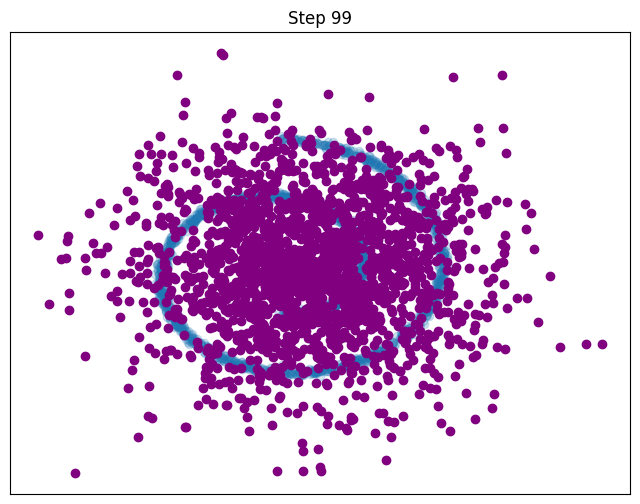

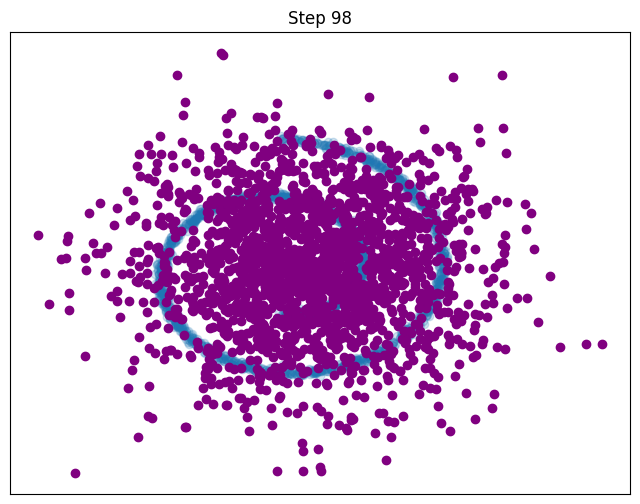

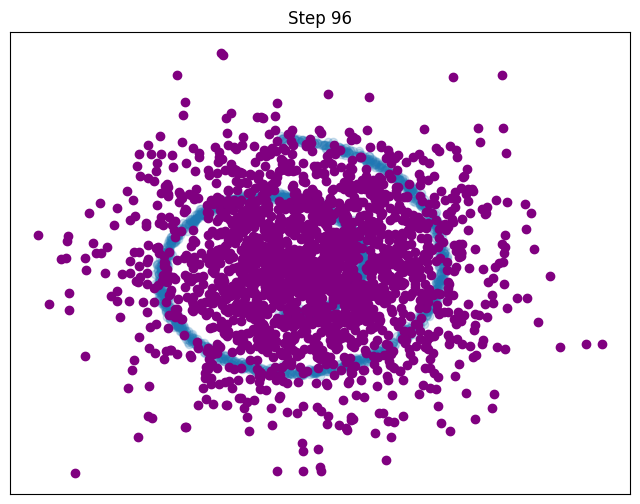

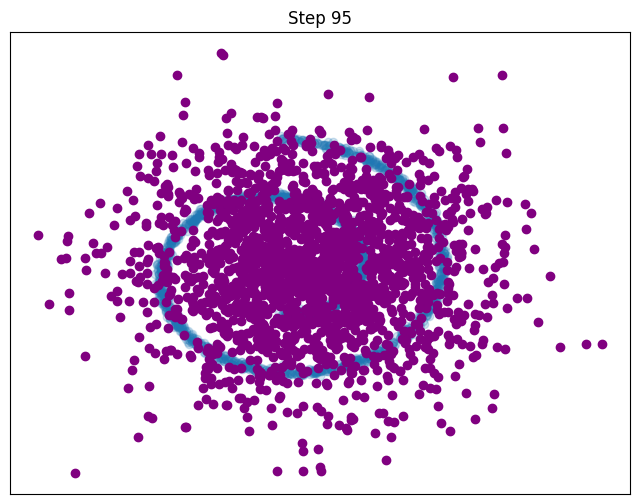

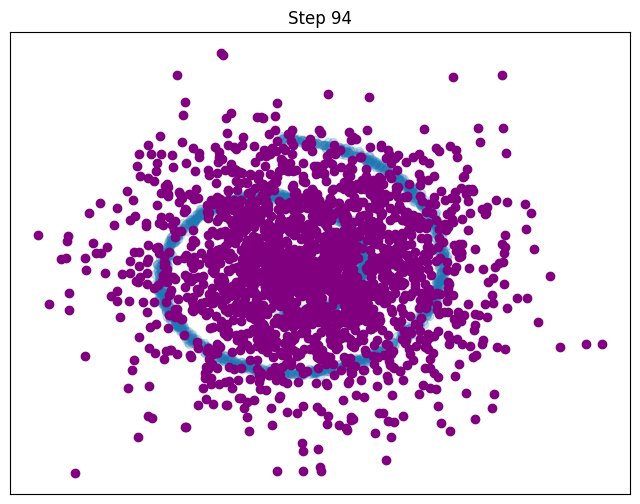

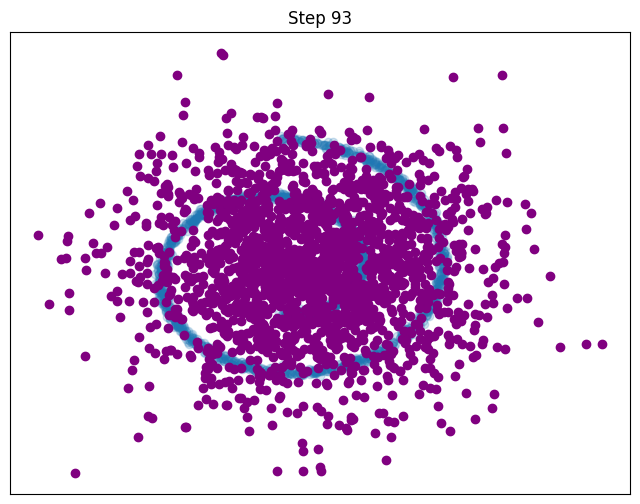

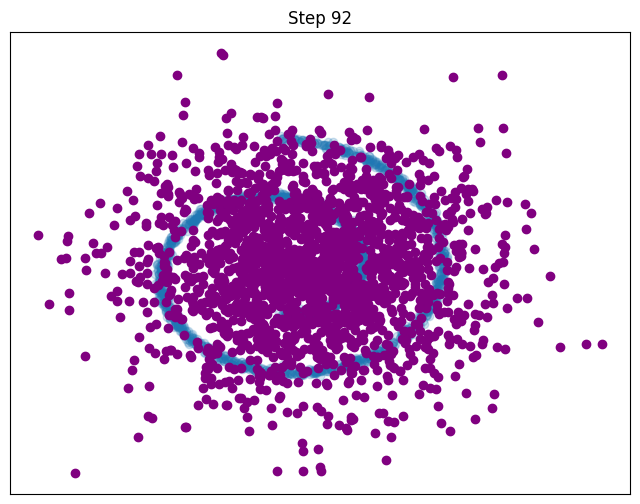

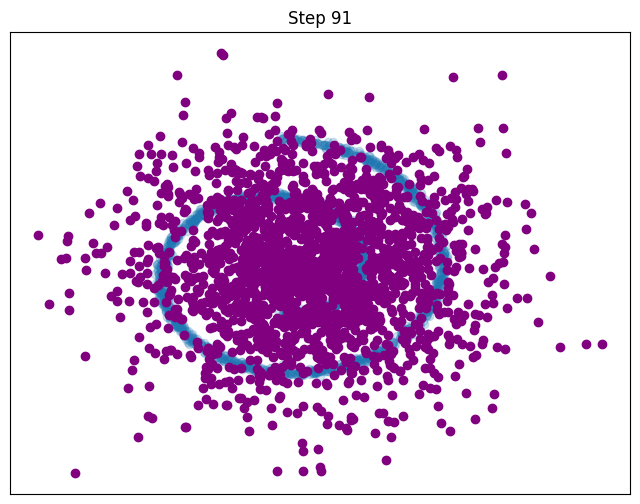

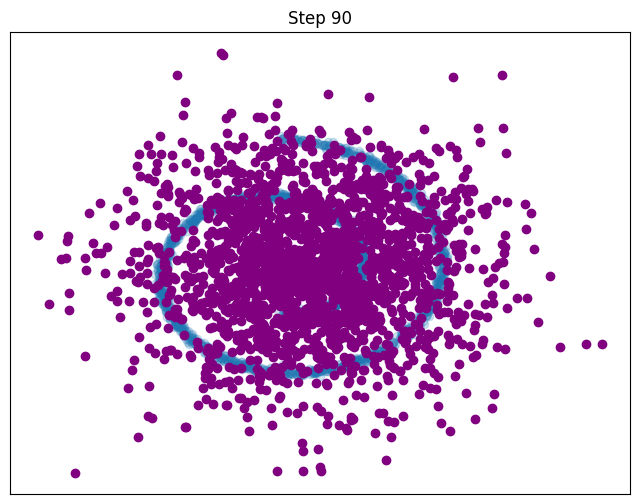

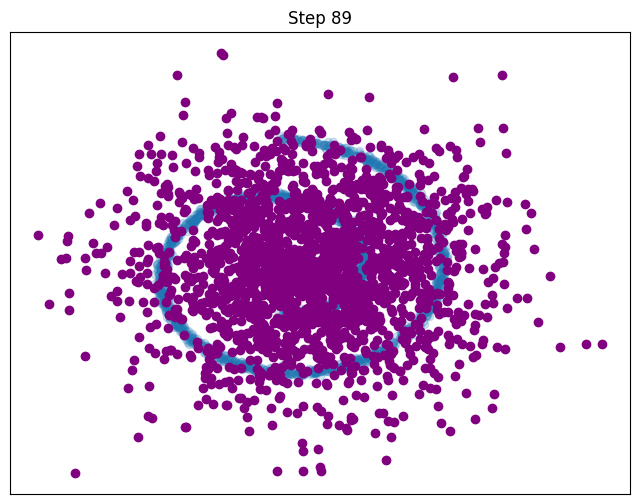

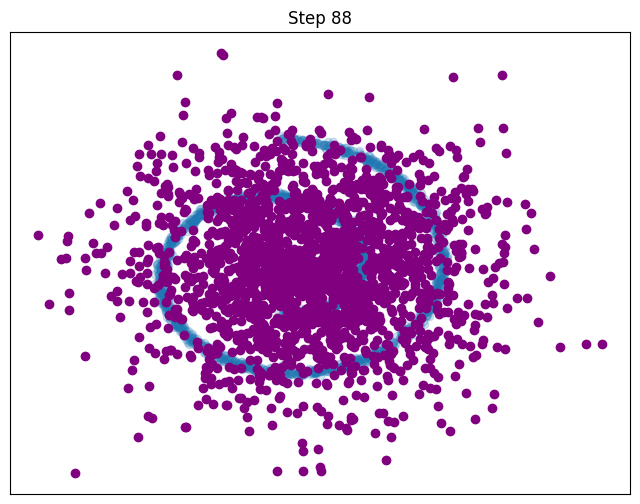

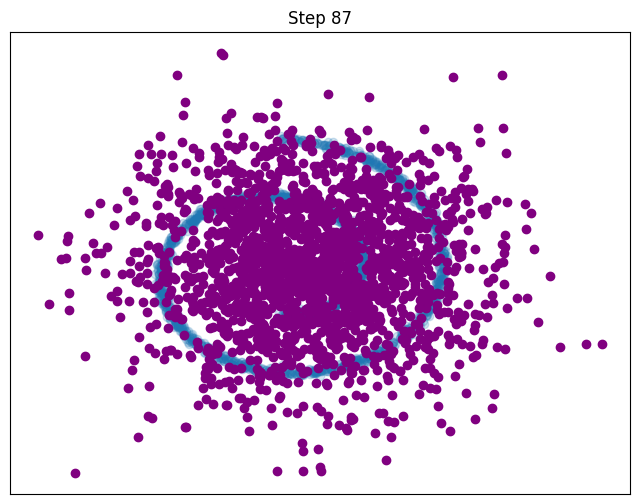

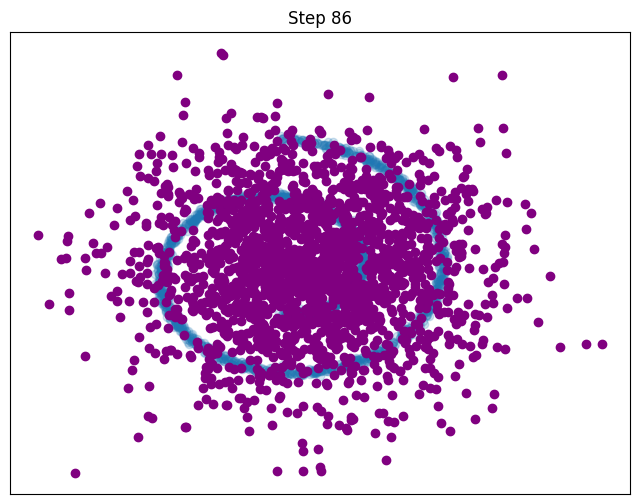

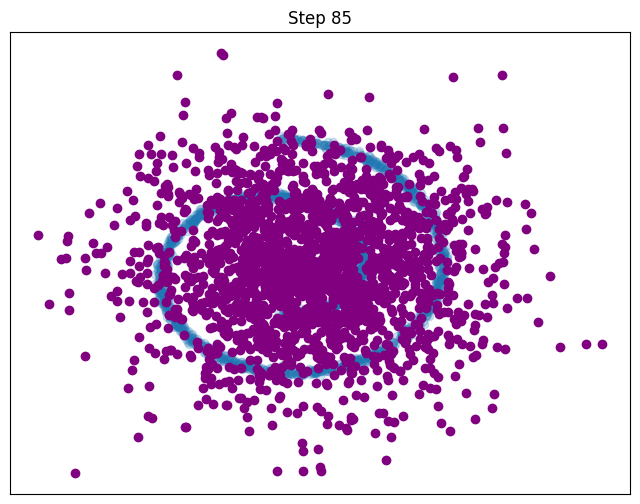

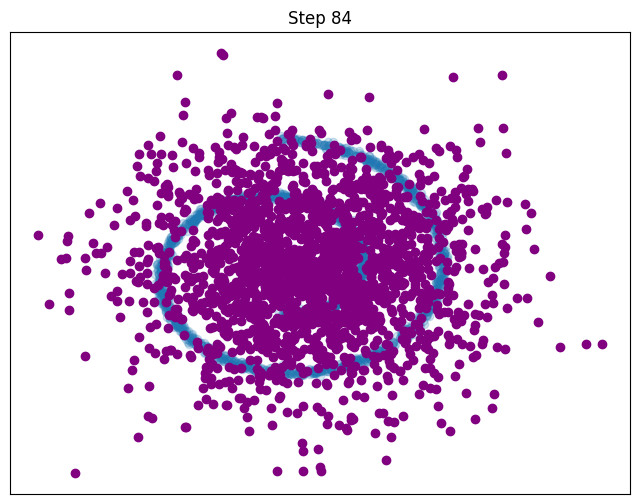

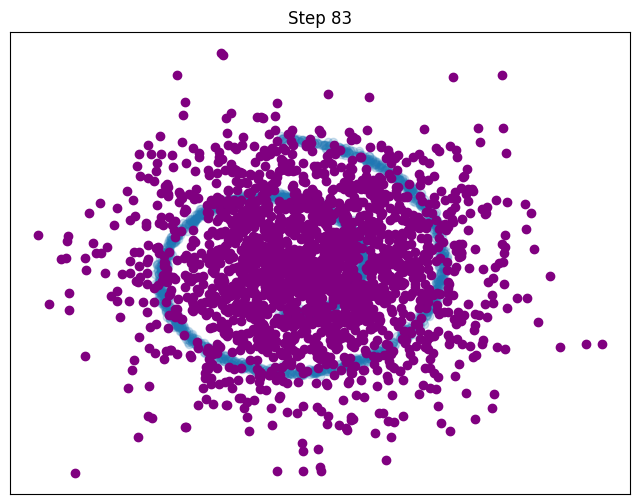

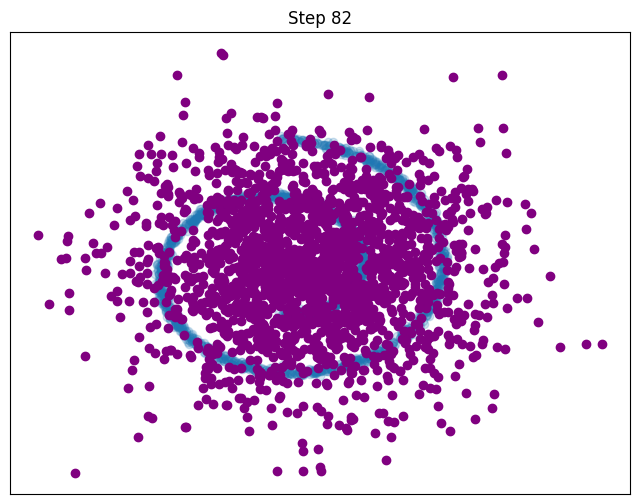

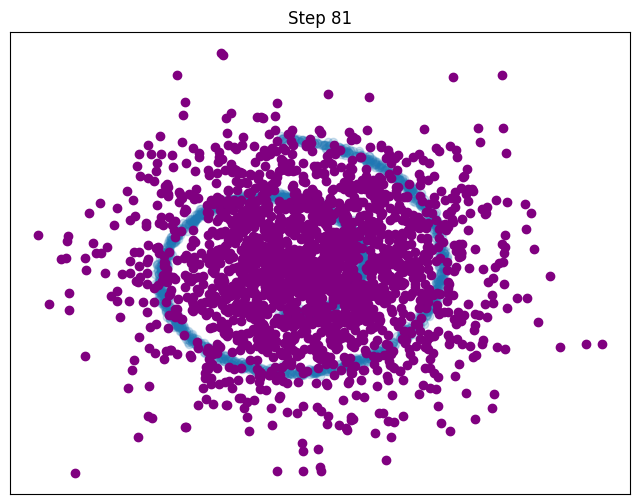

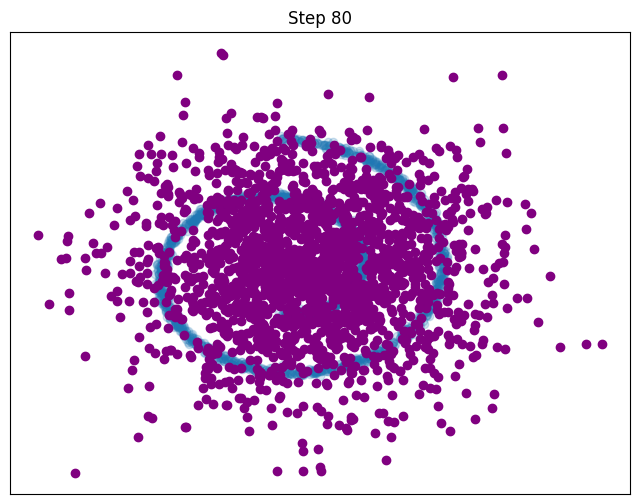

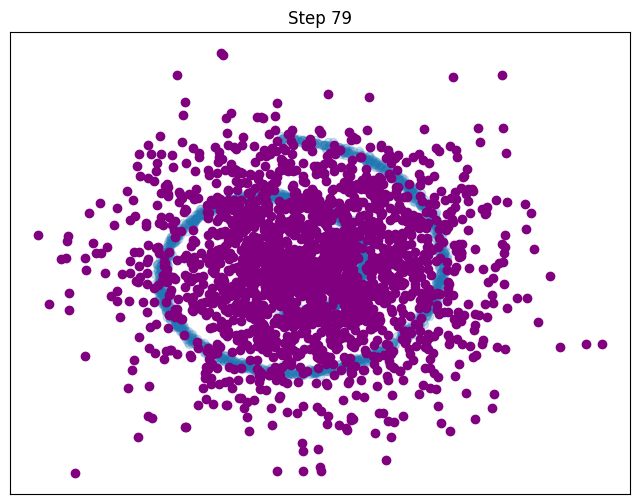

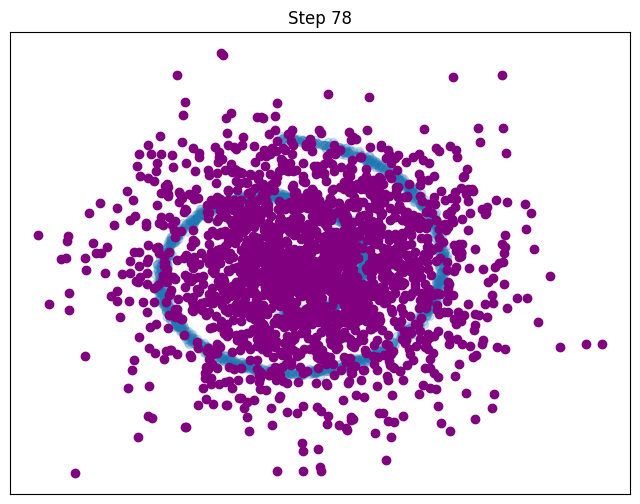

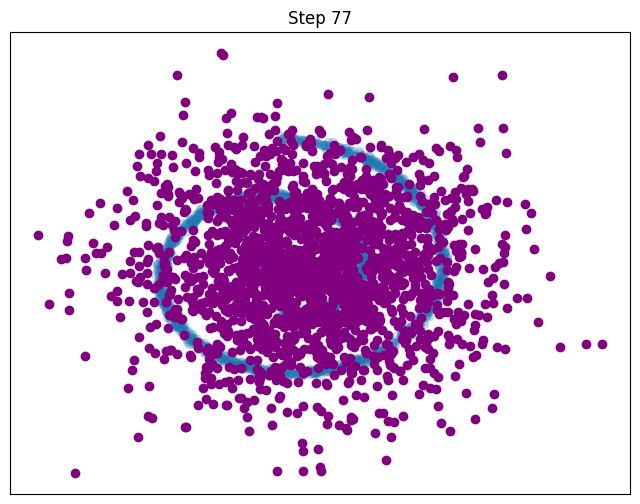

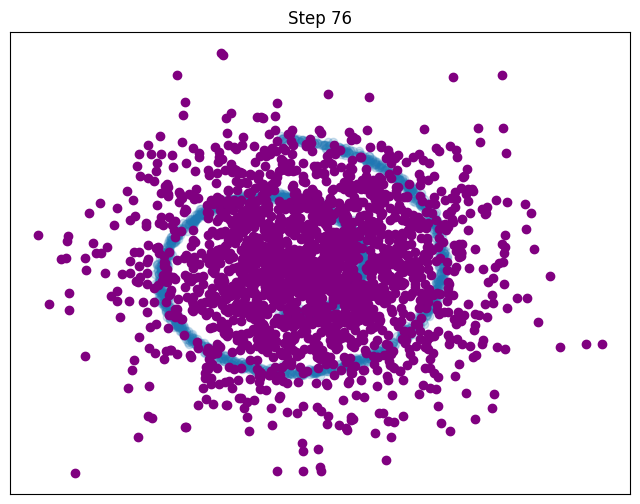

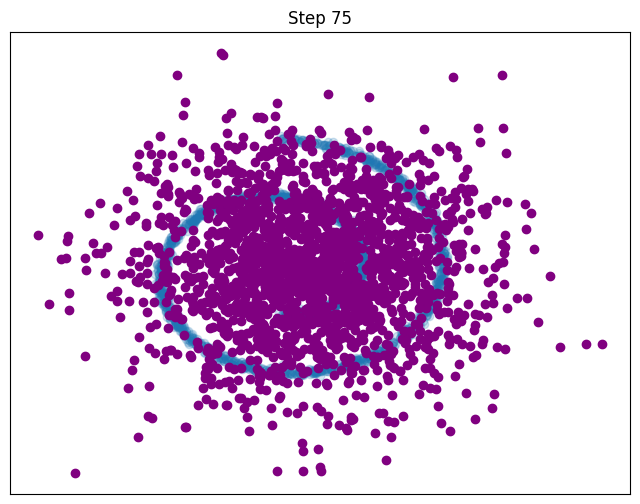

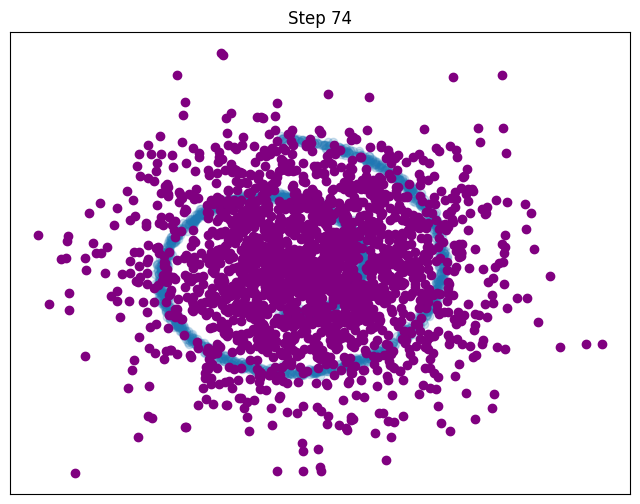

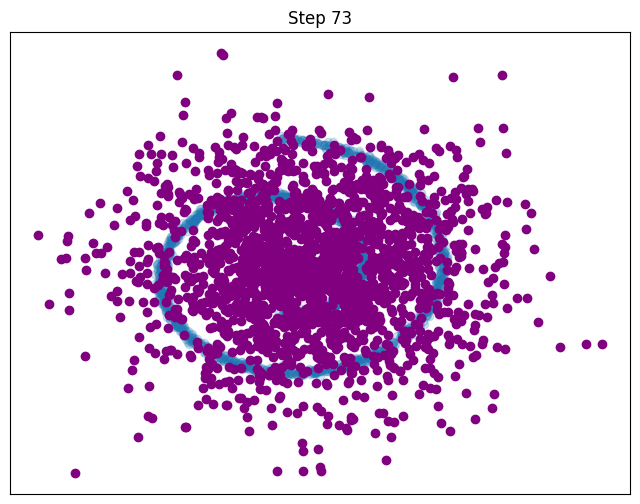

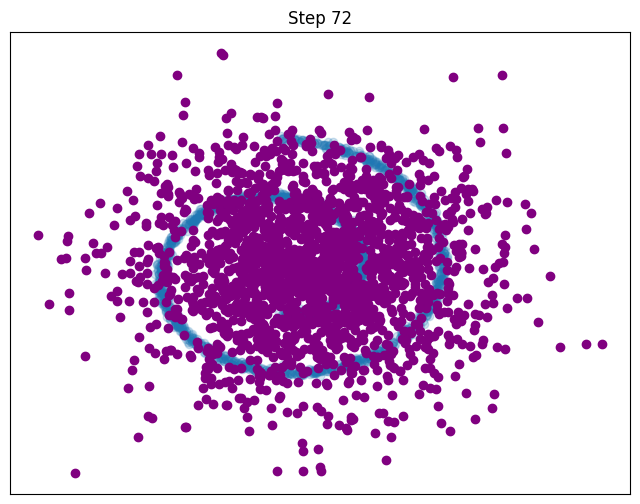

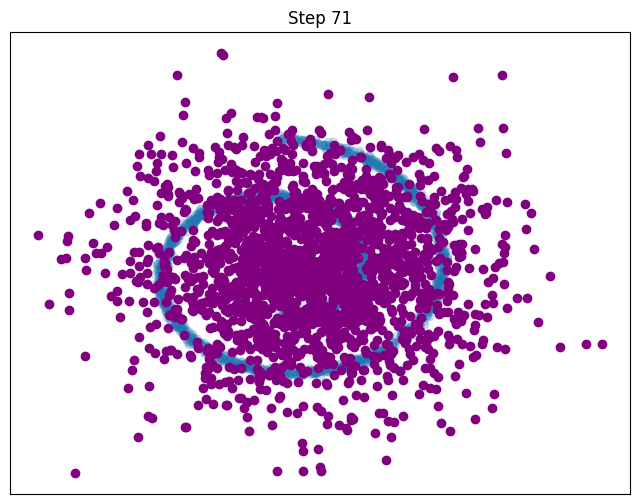

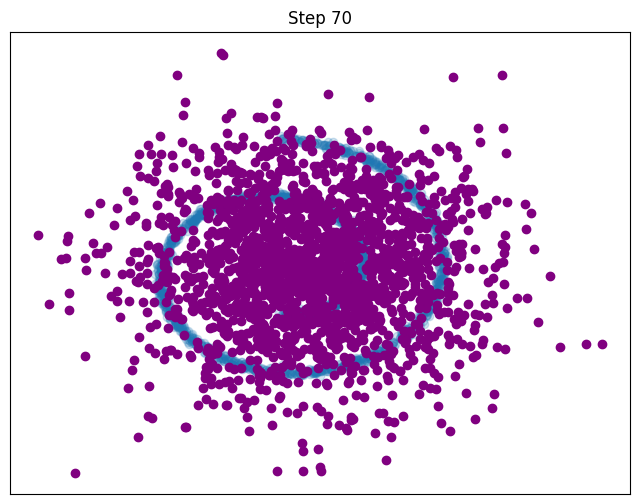

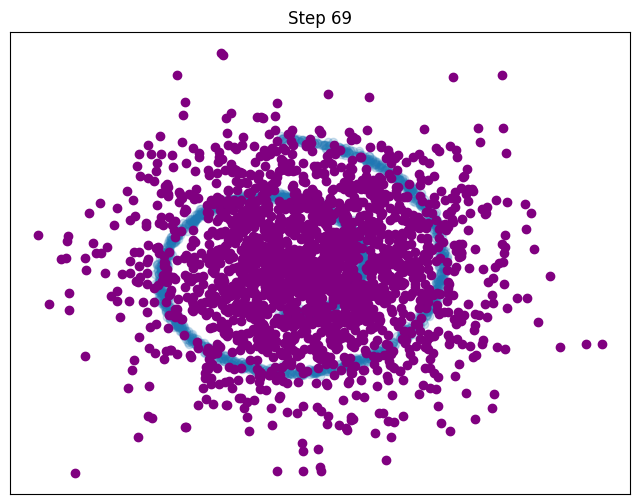

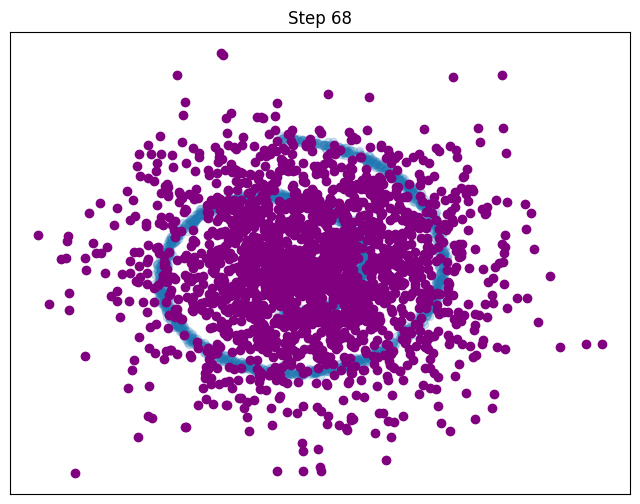

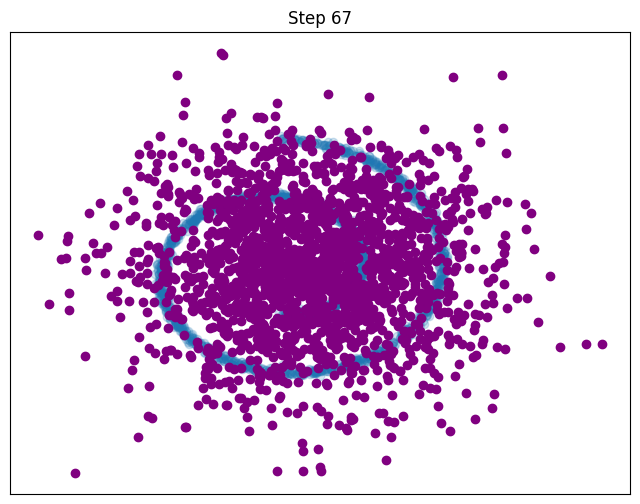

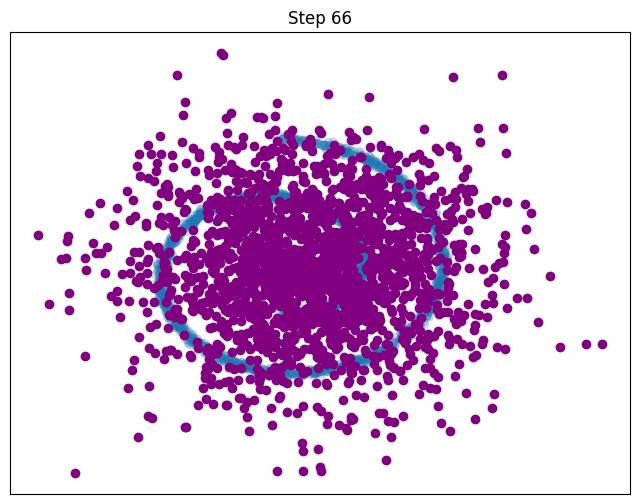

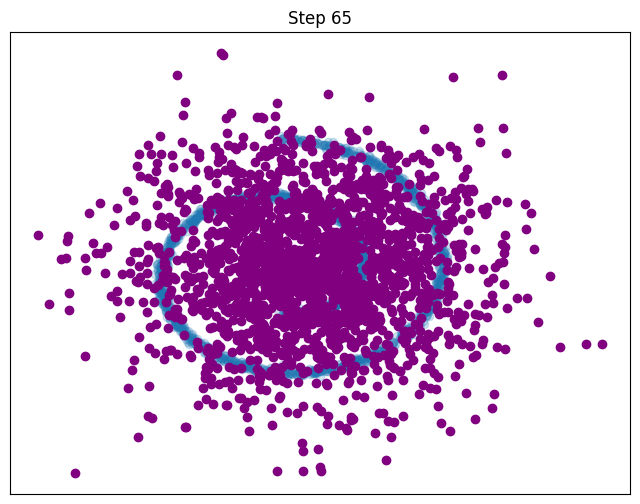

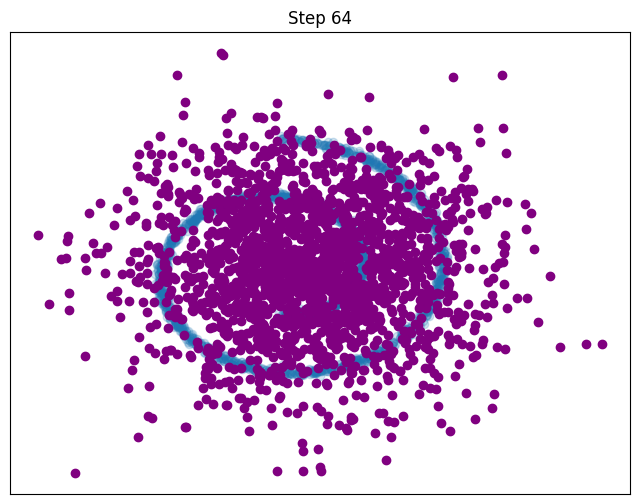

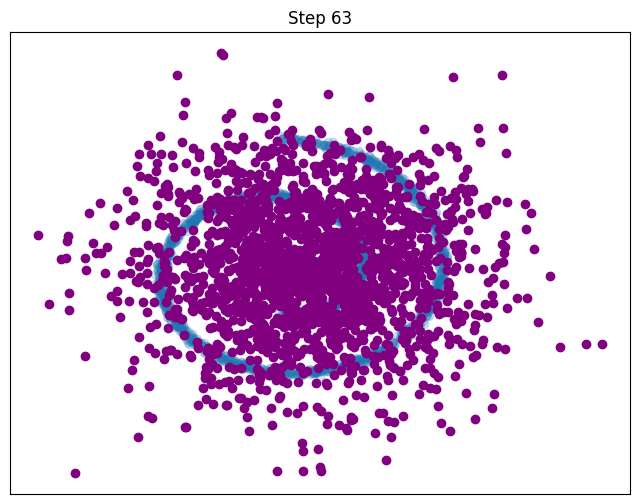

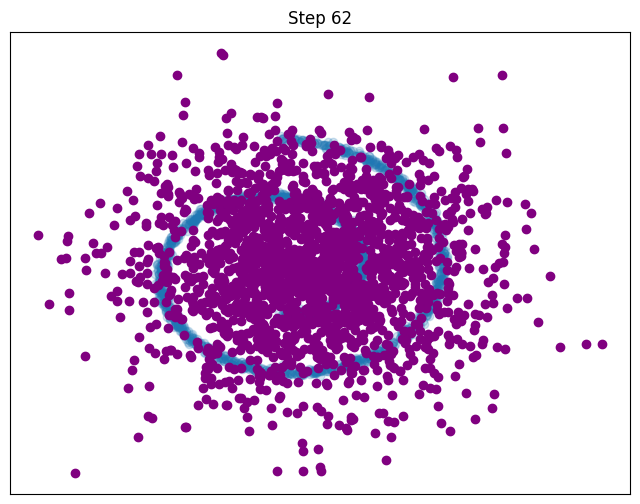

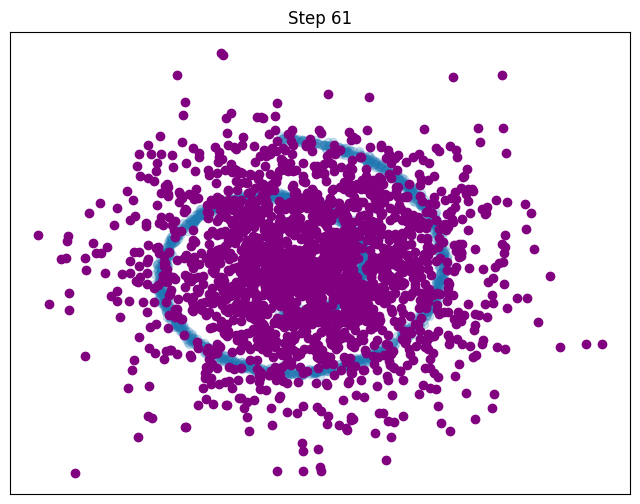

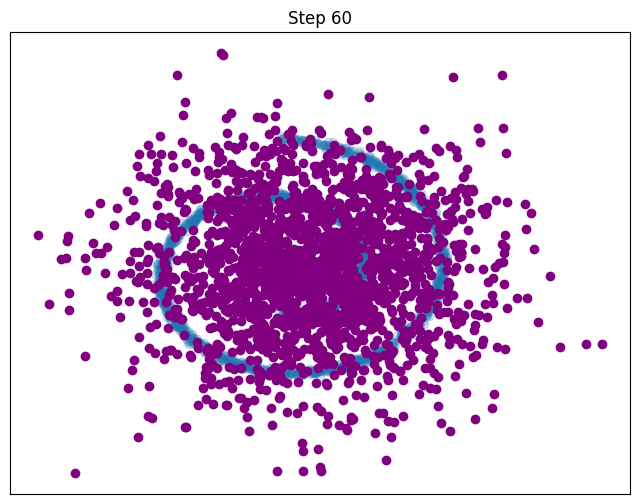

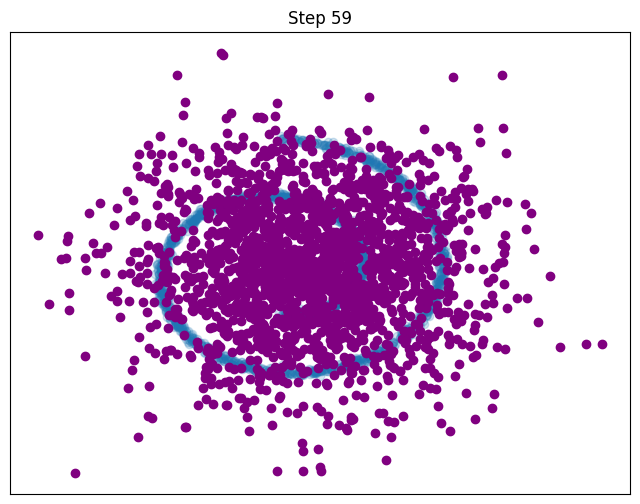

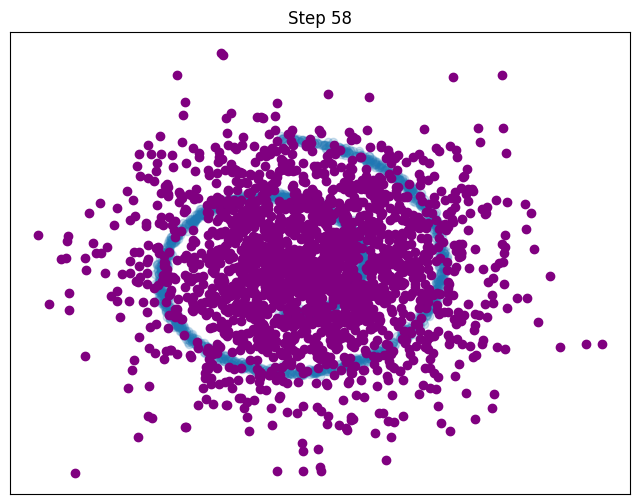

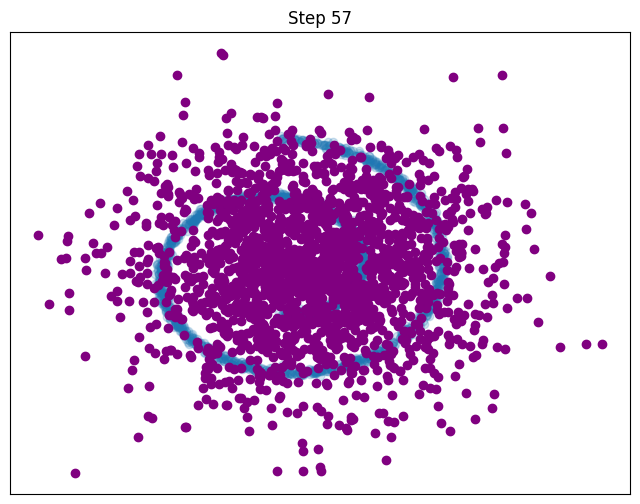

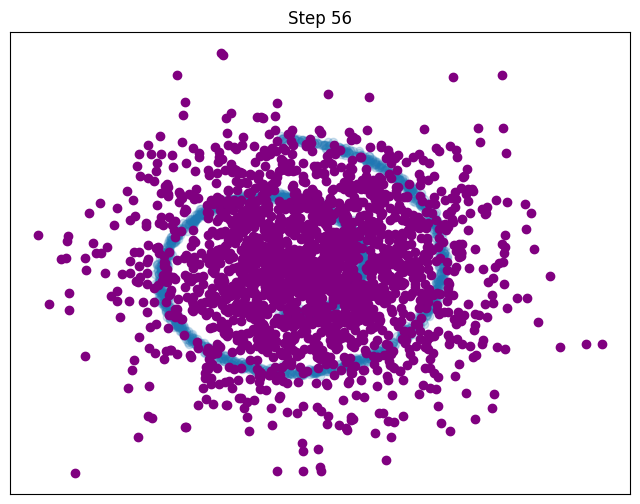

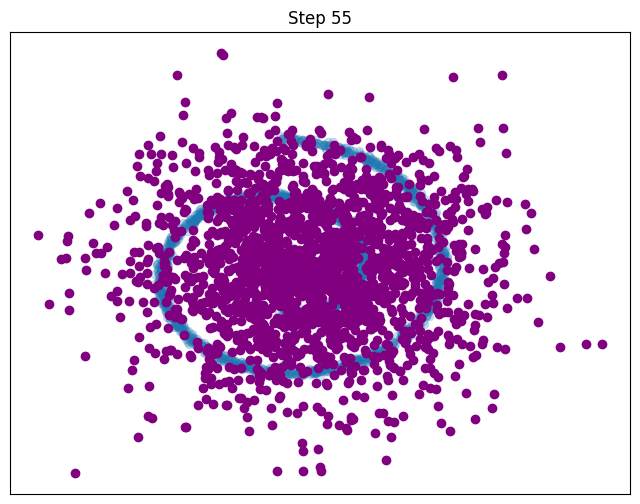

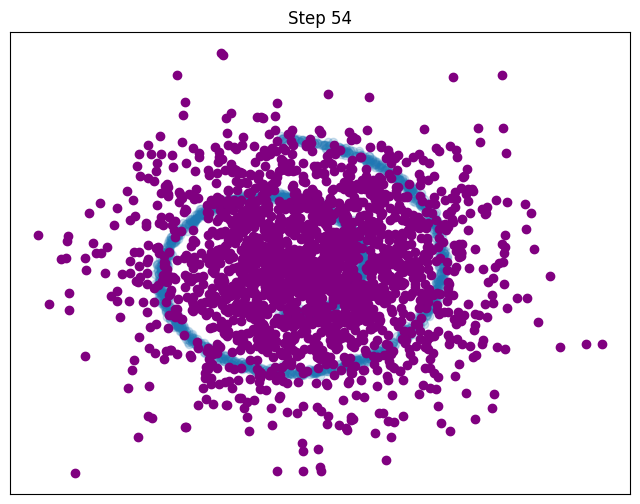

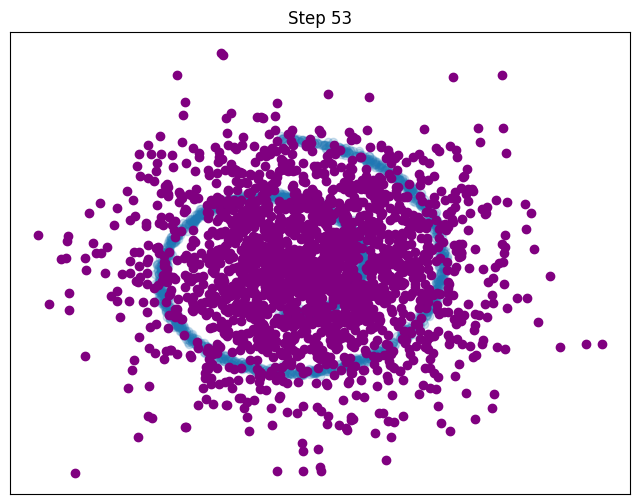

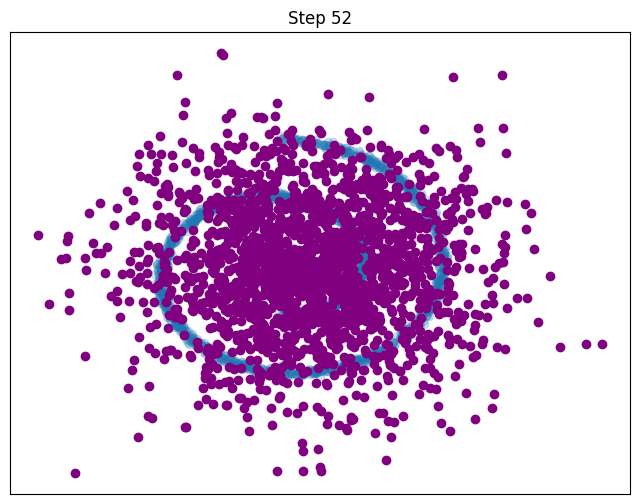

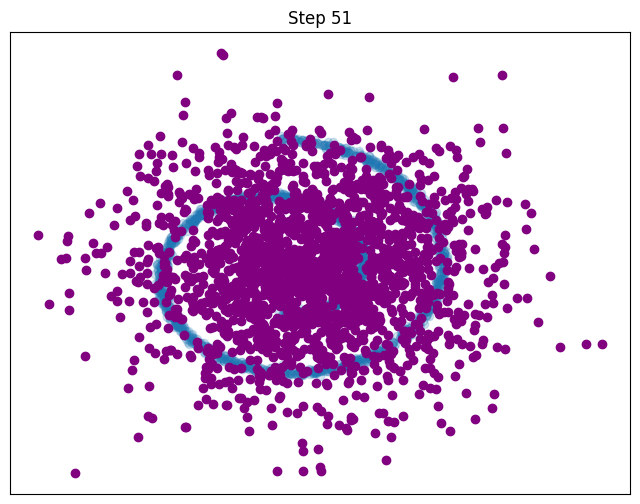

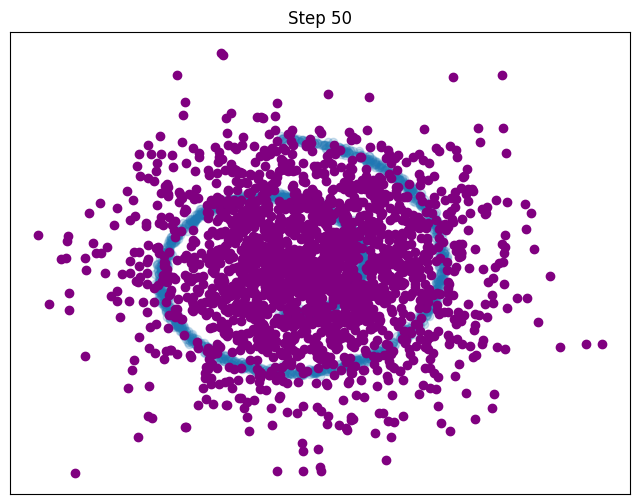

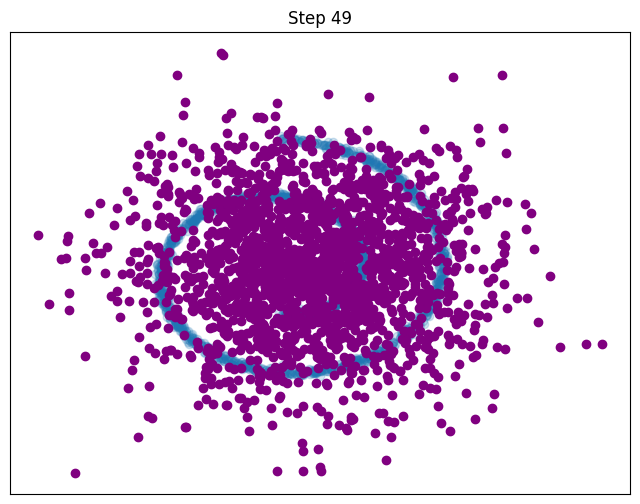

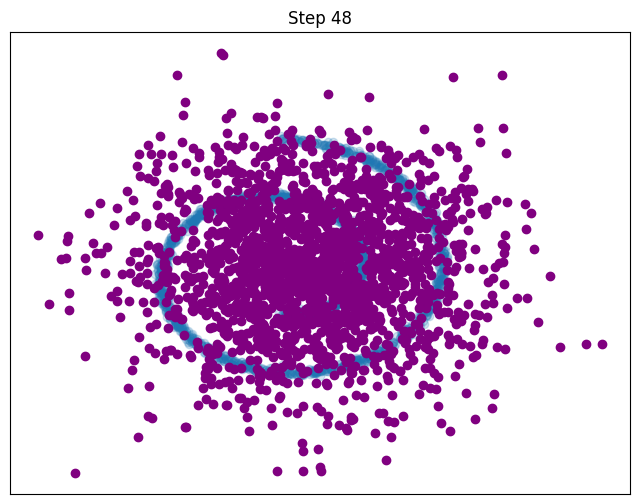

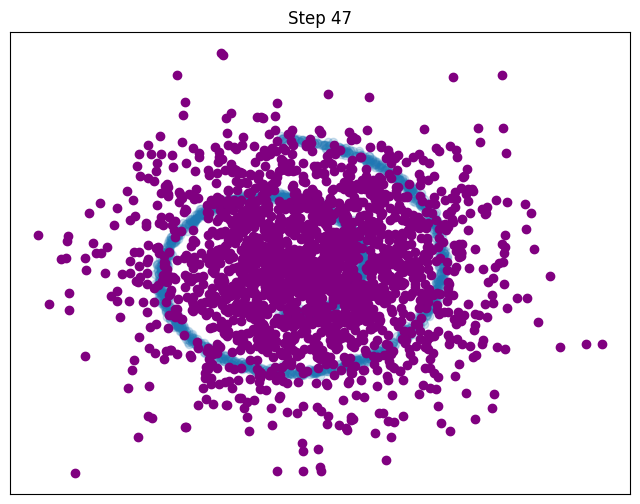

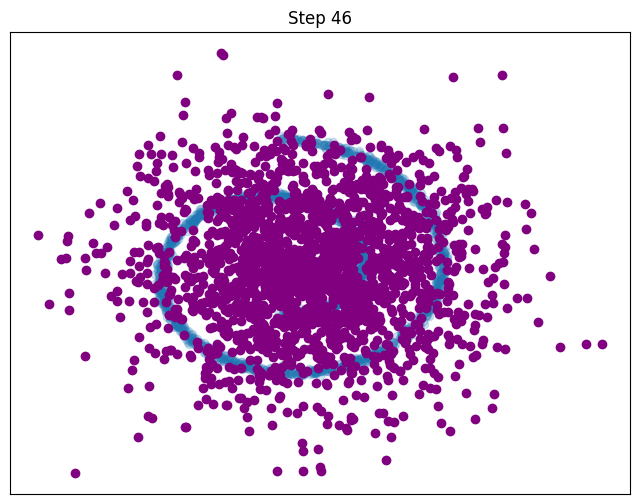

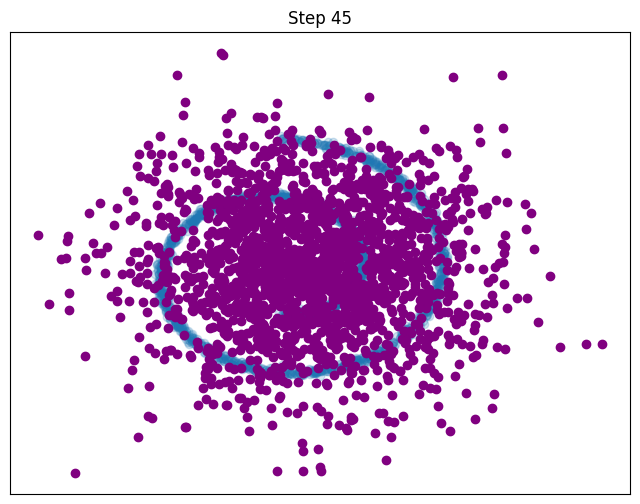

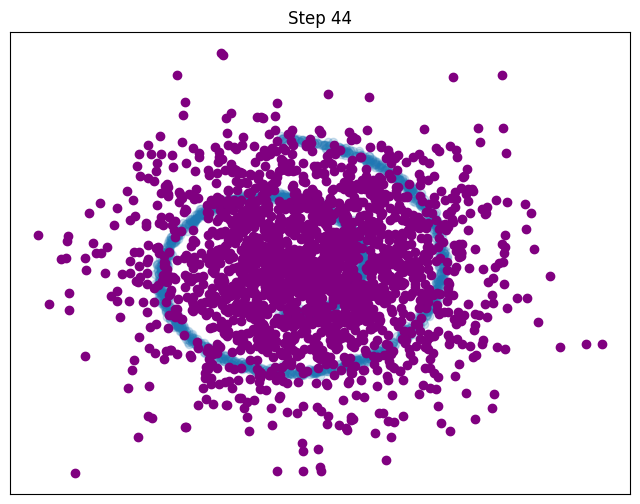

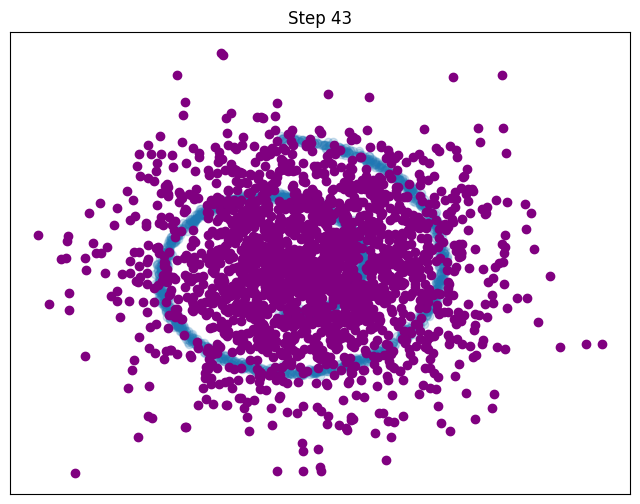

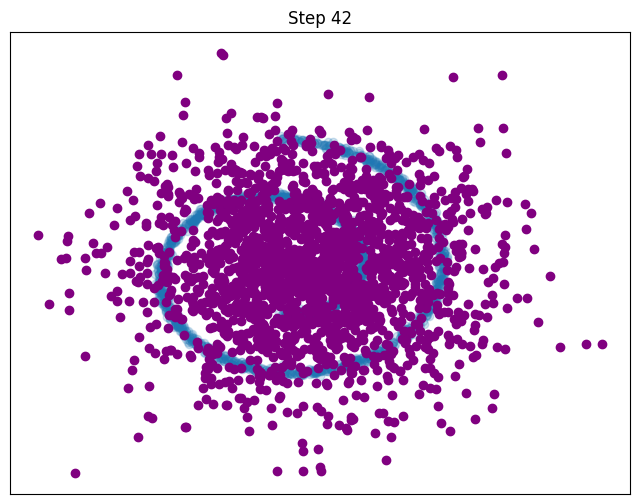

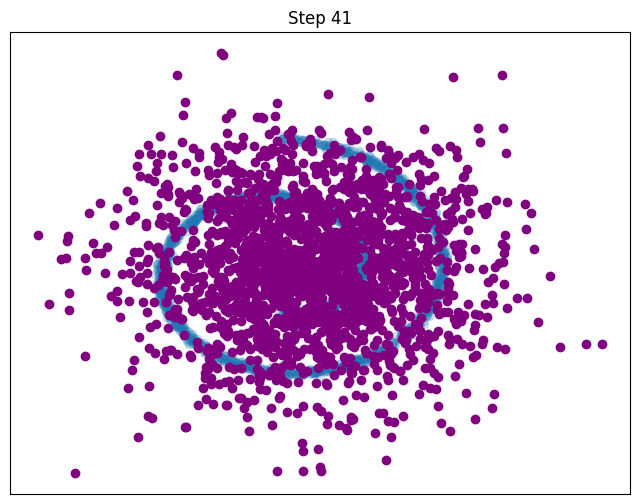

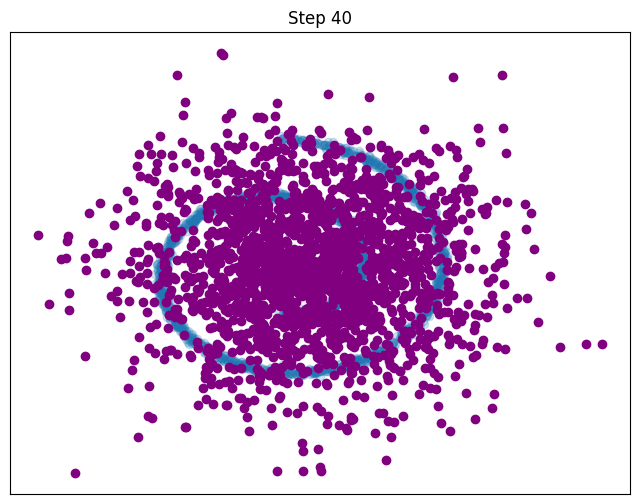

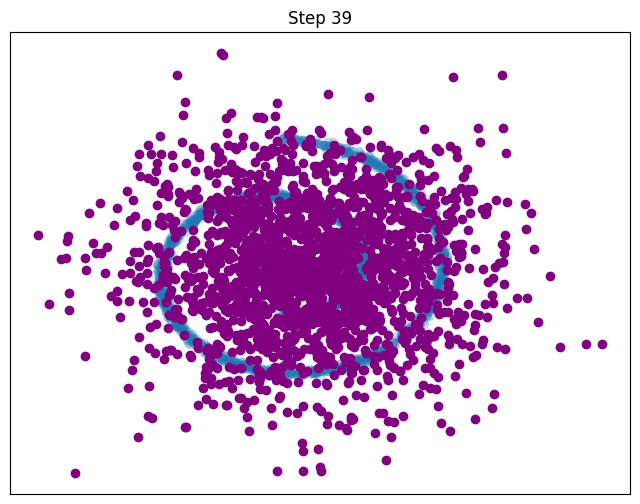

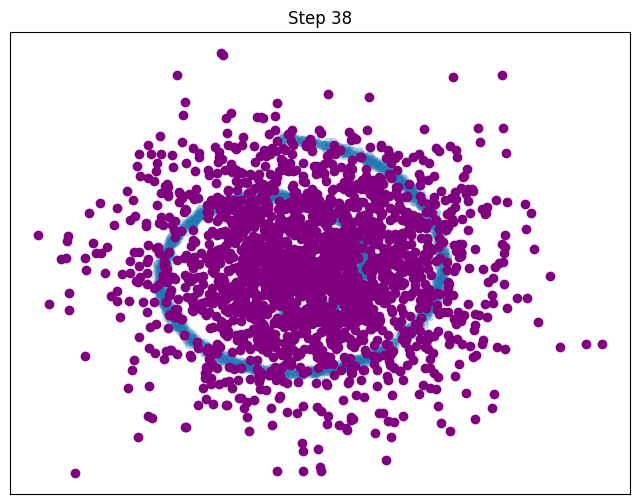

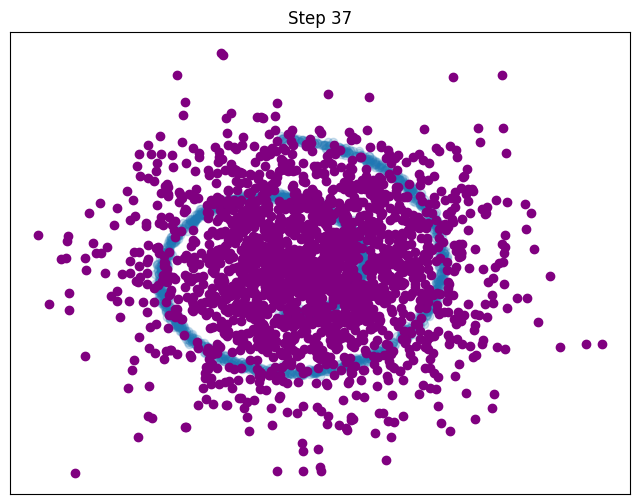

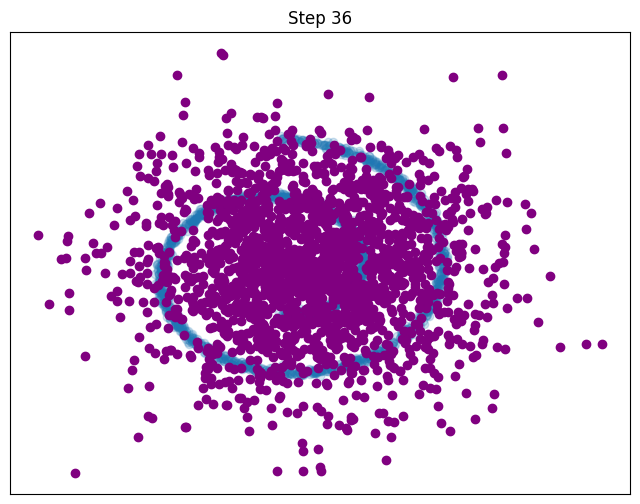

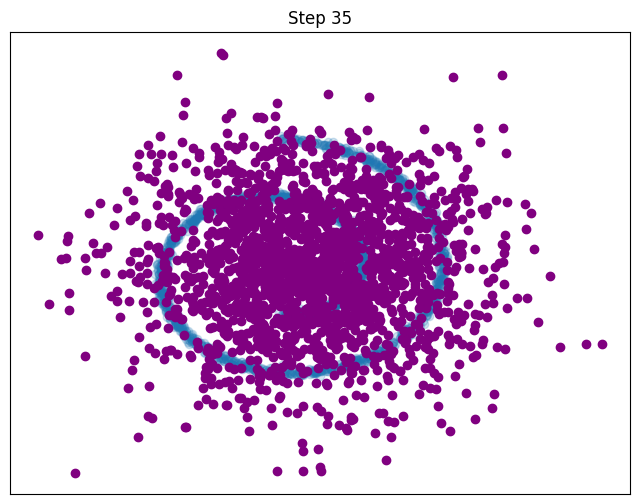

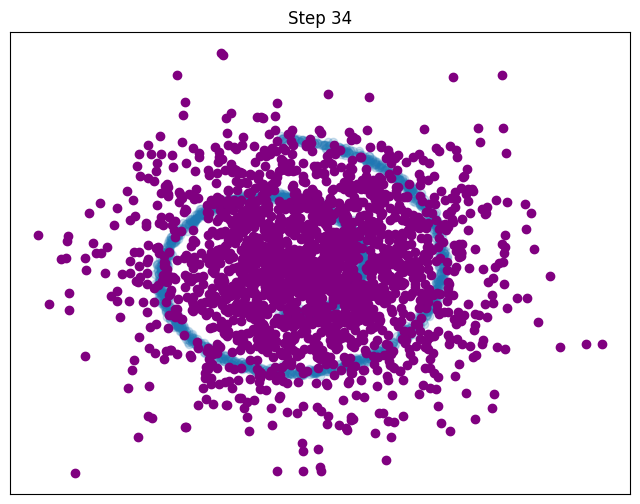

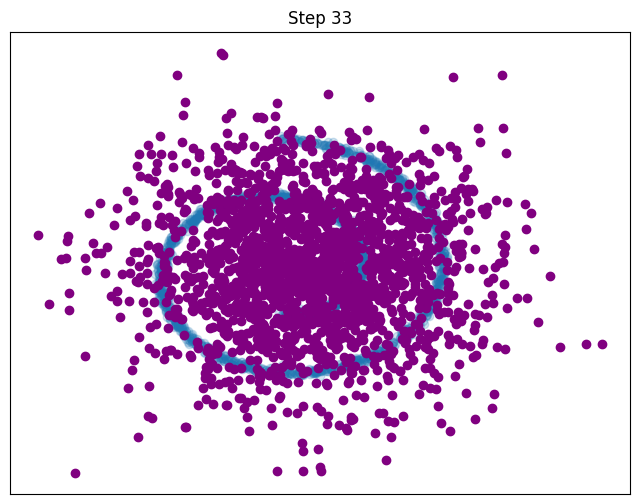

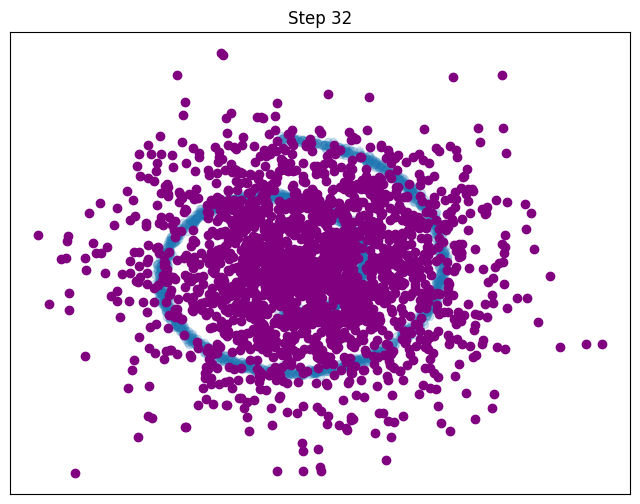

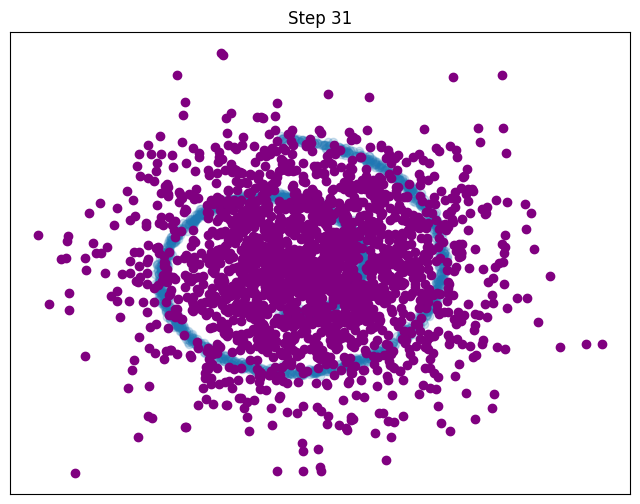

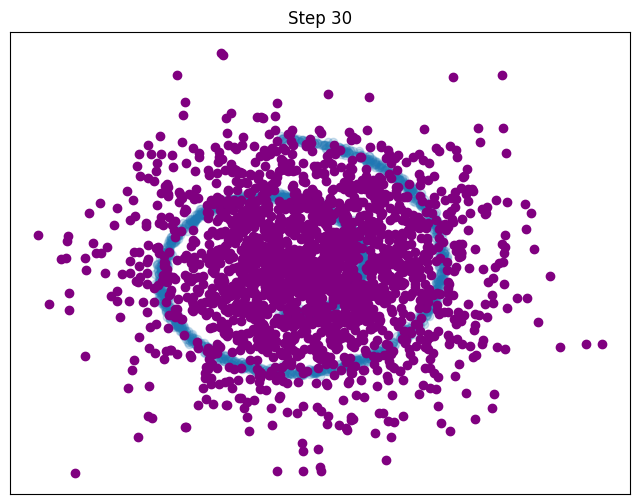

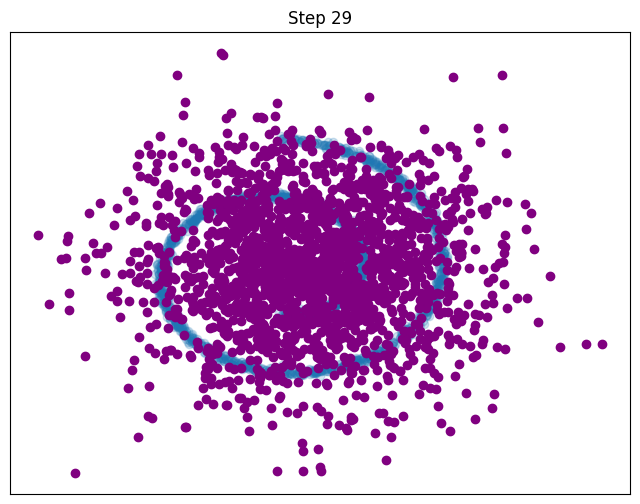

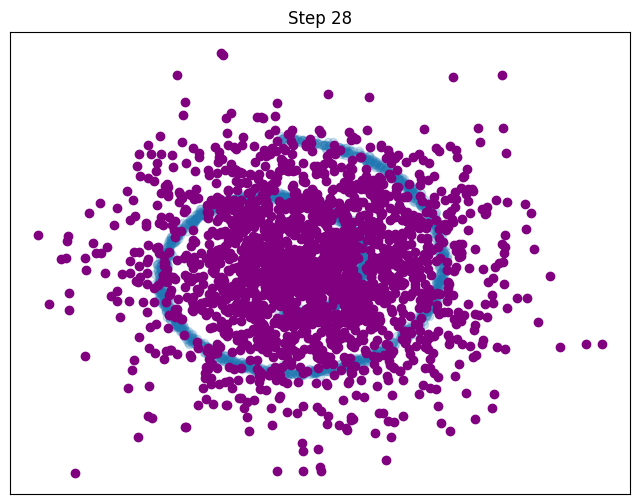

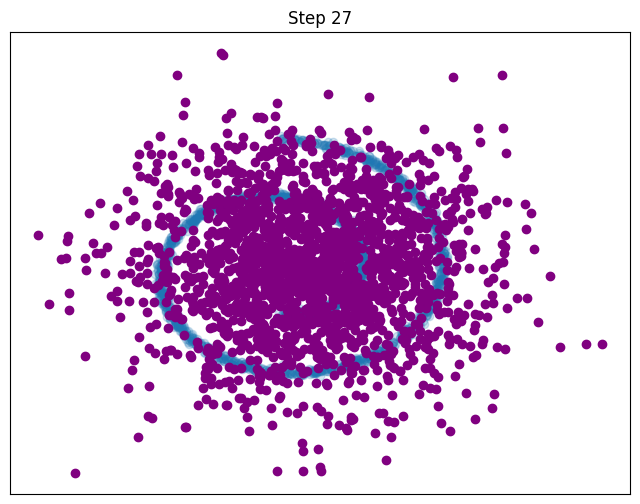

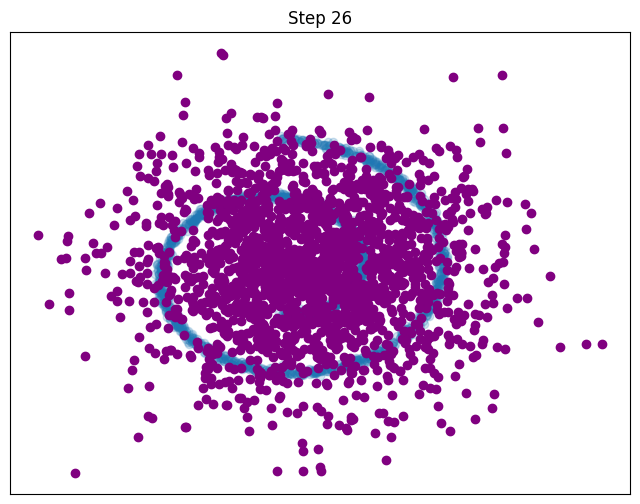

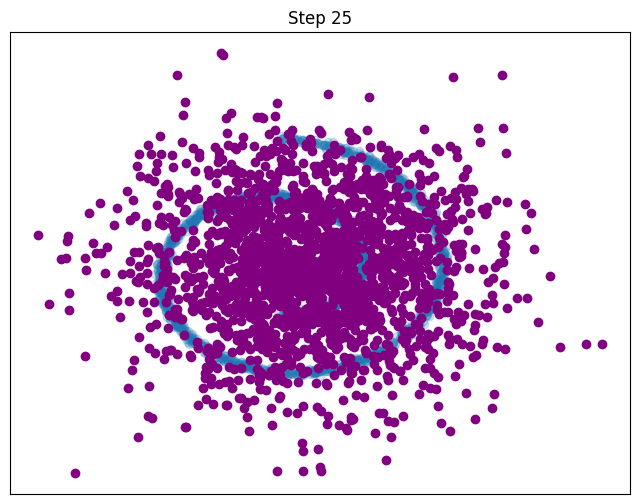

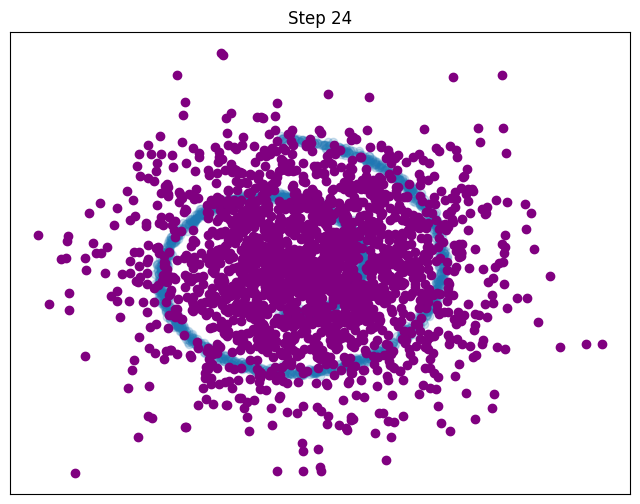

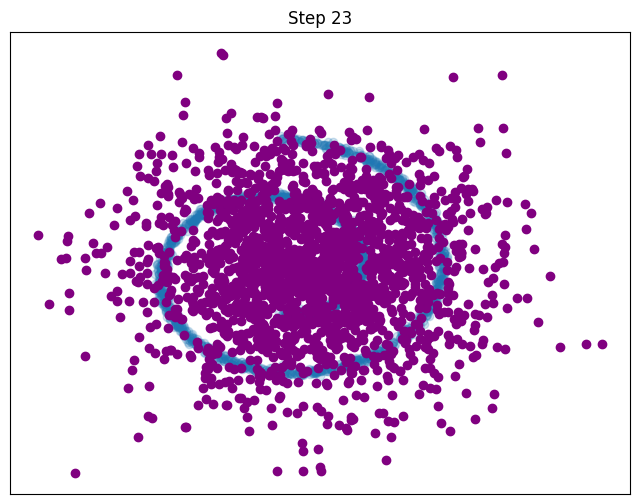

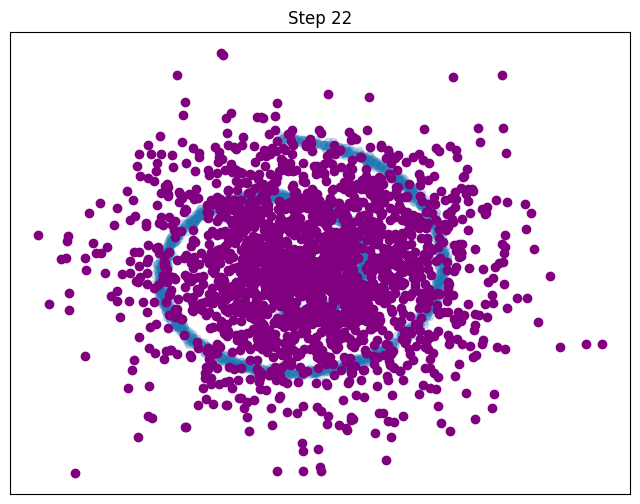

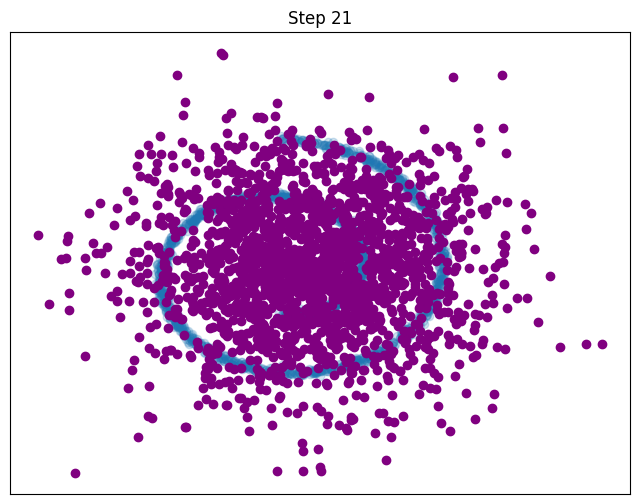

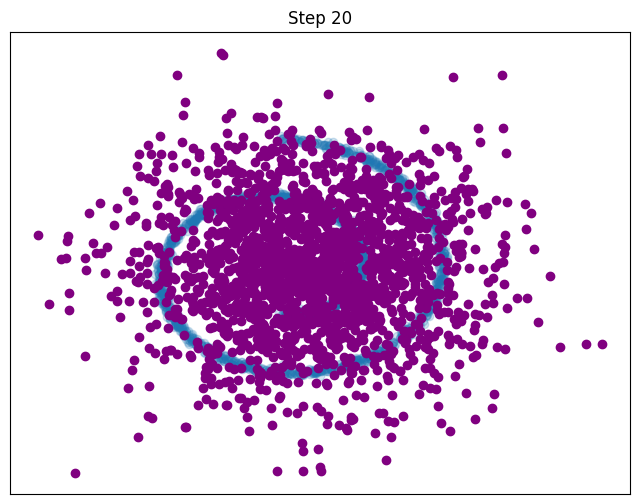

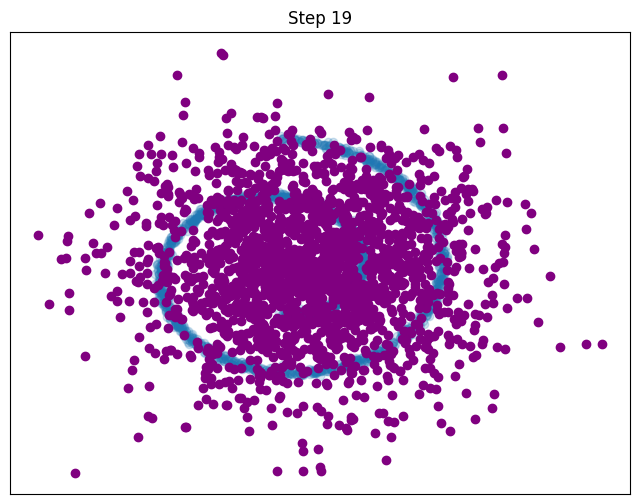

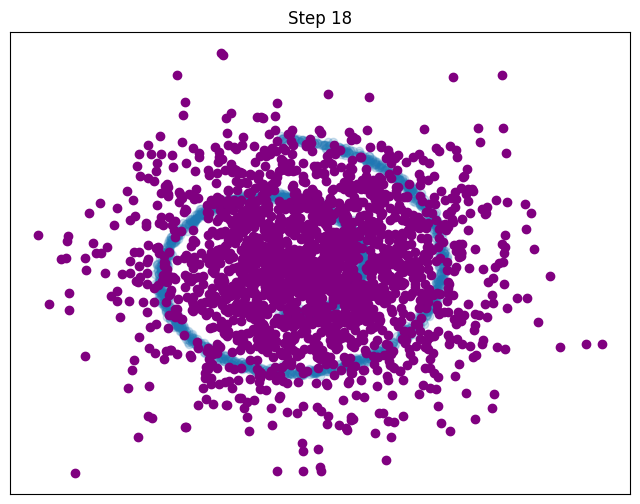

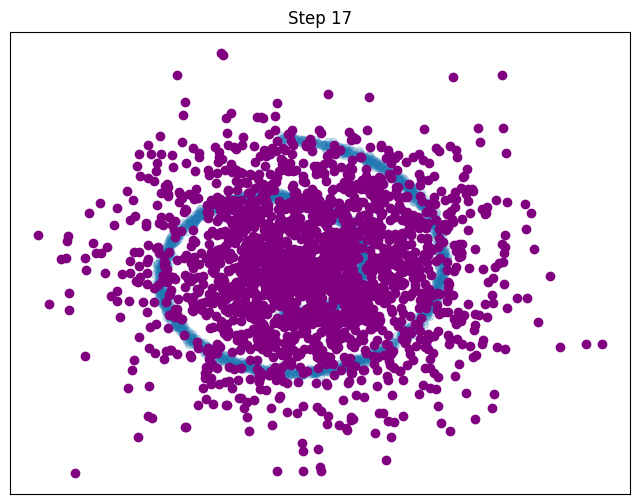

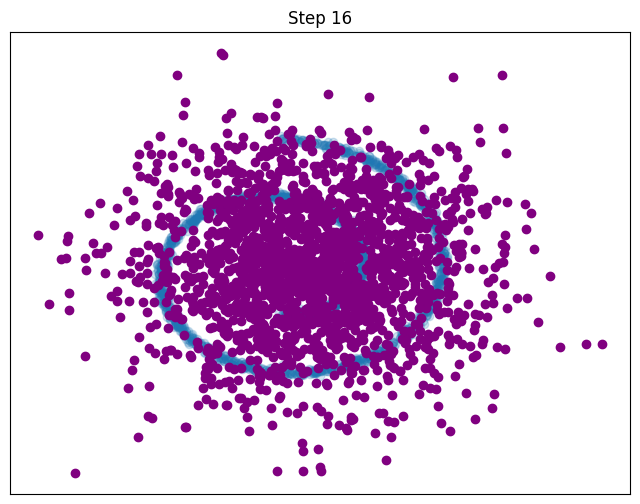

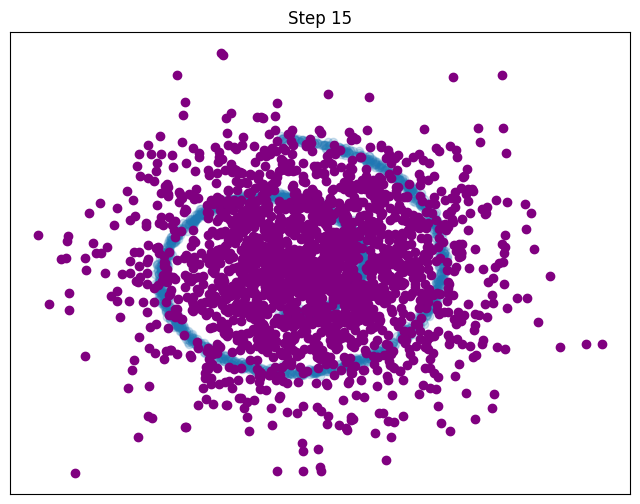

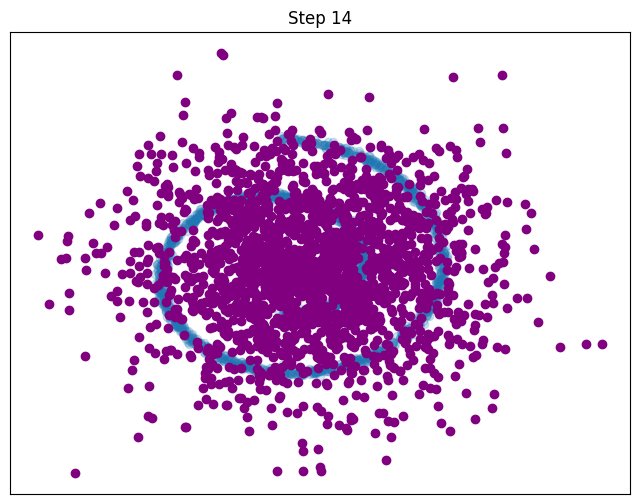

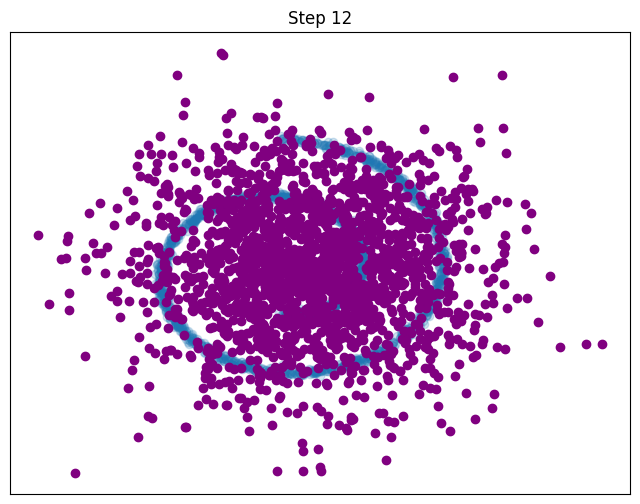

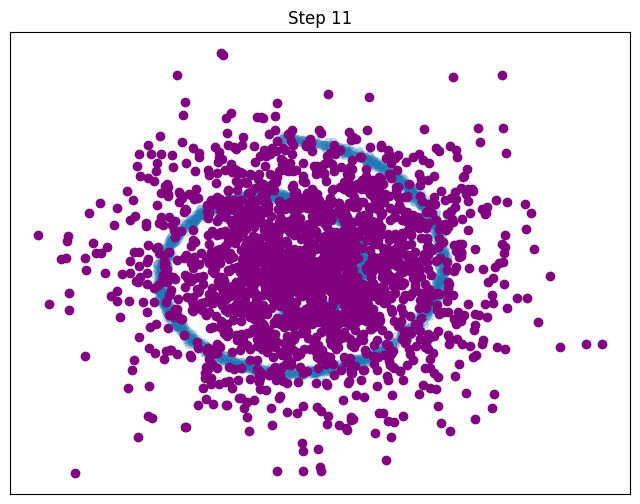

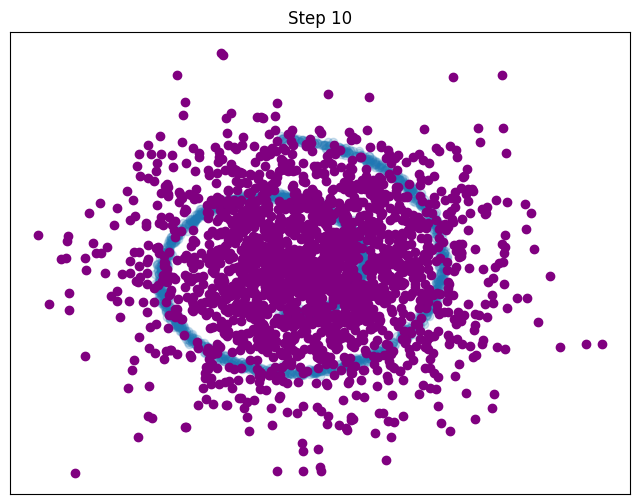

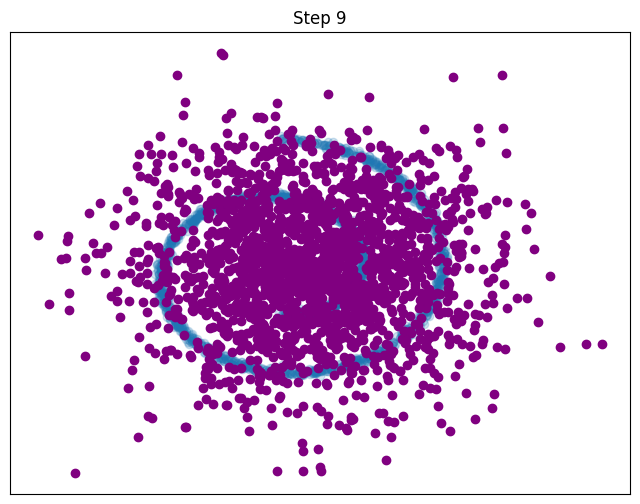

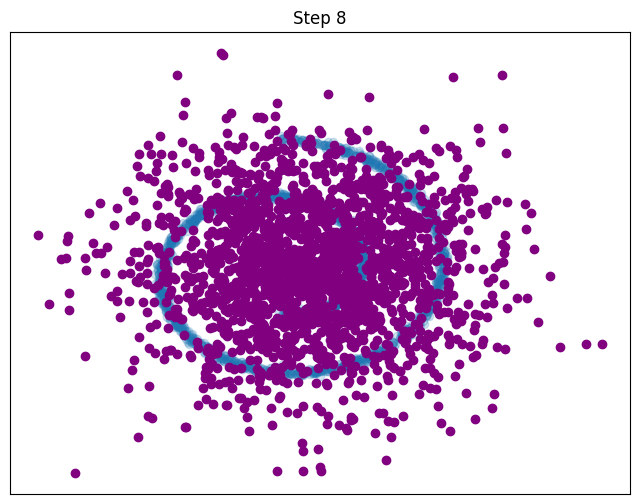

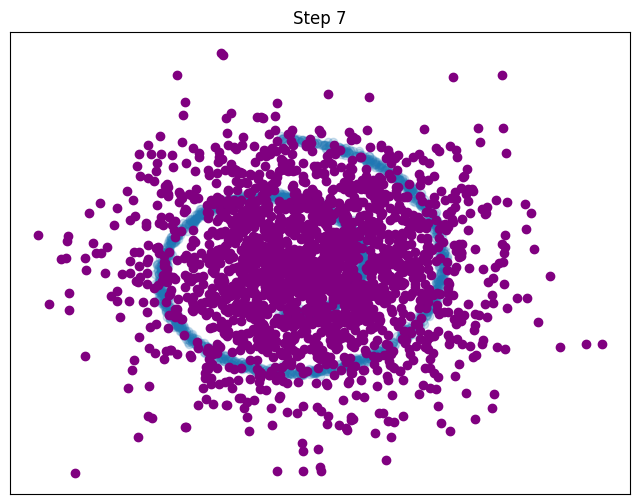

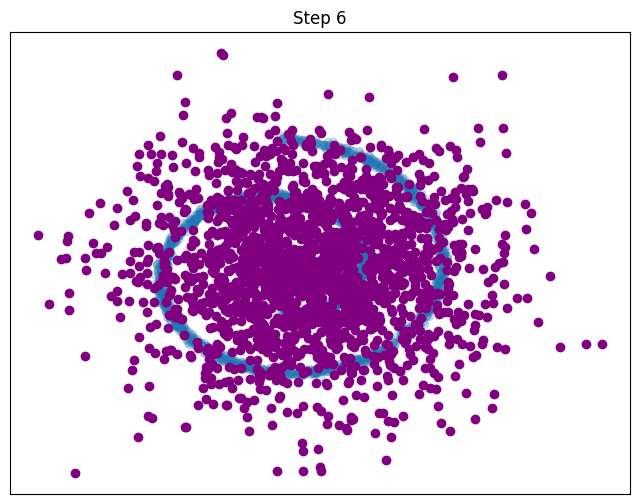

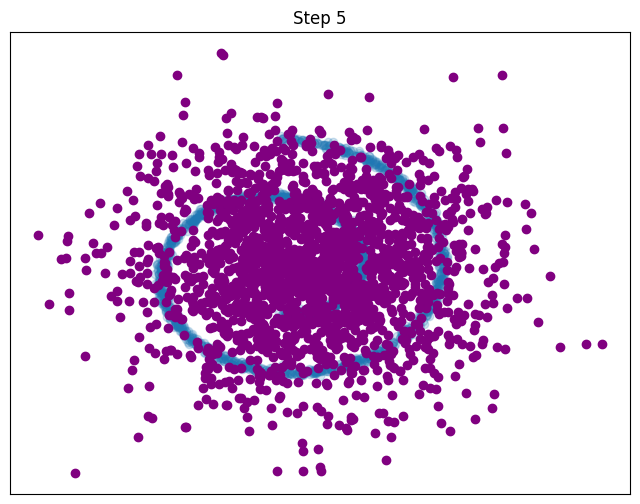

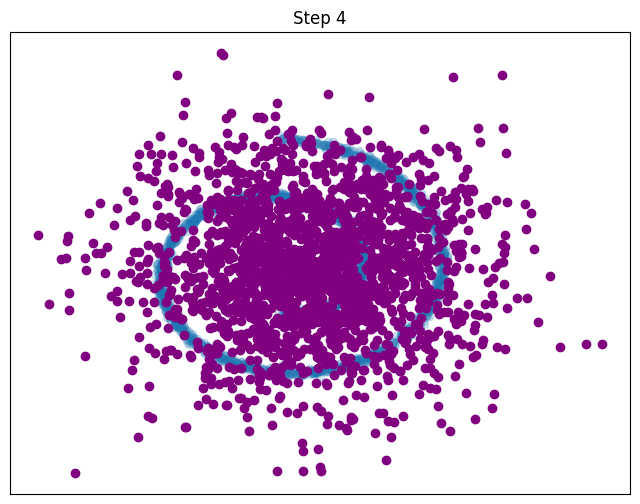

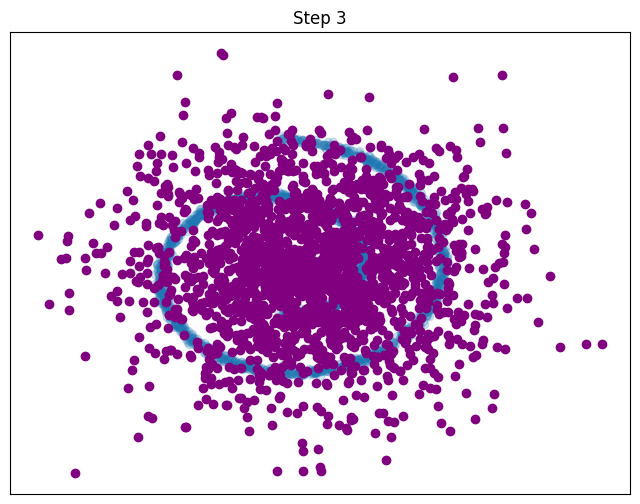

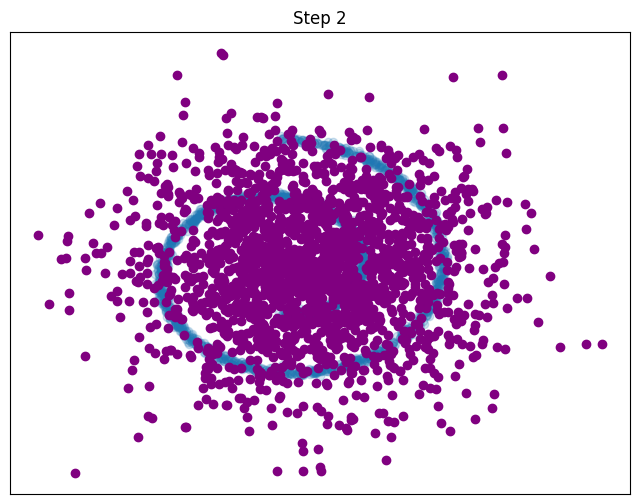

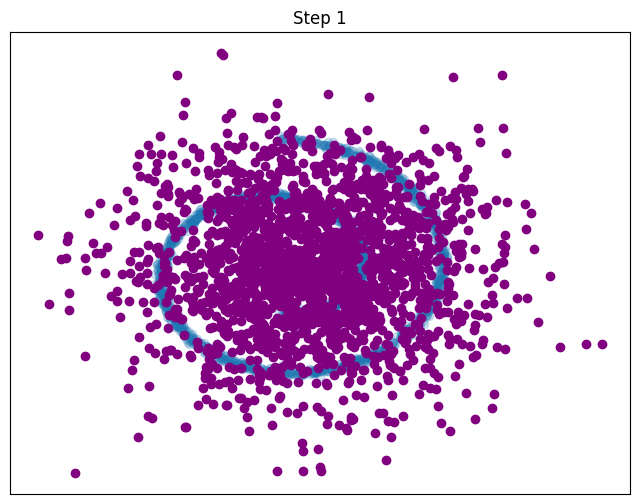

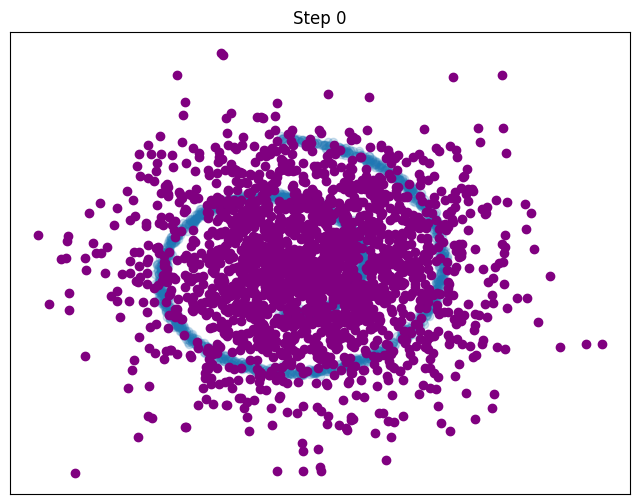

In [108]:
@torch.no_grad()
def recreate_data(model, data_points):
    model.eval()
    timesteps = noise_scheduler.timesteps

    new_points = data_points.clone()

    for timestep in reversed(range(timesteps)):
        # Predict noise at current timestep
        predicted_noise = model(new_points, timestep)
        # Update new_points based on predicted noise

        sqrt_alpha_t, sqrt_one_minus_alpha_bar_t = noise_scheduler.get_index(timestep)

        x0_t = (data_points - sqrt_one_minus_alpha_bar_t * predicted_noise) / sqrt_alpha_t

        if timestep > 0:
            noise = torch.randn_like(data_points)
            x = x0_t + torch.sqrt(noise_scheduler.betas[timestep]) * noise
        else:
            x = x0_t

        # Create a new figure for the current timestep
        plt.figure(figsize=(8, 6))  # You can adjust the size as needed
        # Plot the original data and the current state of new_points
        plot_data_points(data[:], new_points)
        plt.title(f"Step {timestep}")  # Set a title with the current timestep
        plt.show()

    # Optionally, show the final result
    plt.figure(figsize=(8, 6))
    plot_data_points(data[:], new_points)
    plt.title("Final result")
    plt.show()



eval_vecs = torch.randn((2000,2)).to(device)

recreate_data(noise_model, eval_vecs)